# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [30]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [31]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [32]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [33]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer=separable_conv2d_batchnorm(input_layer,filters,strides)
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [34]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    
    output_layer=bilinear_upsample(small_ip_layer)
    
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    
    output_layer=layers.concatenate([output_layer, large_ip_layer])
    
    # TODO Add some number of separable convolution layers
    
    output_layer=separable_conv2d_batchnorm(output_layer,filters,1)
    output_layer=separable_conv2d_batchnorm(output_layer,filters,1)
    
    
    
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [35]:
def fcn_model(inputs, num_classes):
    
    #  Encoder Blocks.     
    enc=encoder_block(inputs, 32, 2)
    enc2=encoder_block(enc, 64, 2)
    enc3=encoder_block(enc2, 128, 2)

    # 1x1 Convolution layer using conv2d_batchnorm().
    conv_1x1=conv2d_batchnorm(enc3, 256, kernel_size=1, strides=1)
    
    # Decoder Blocks as the number of Encoder Blocks
    dec1=decoder_block(conv_1x1, enc2, 128)
    dec2=decoder_block(dec1, enc, 64)
    x=decoder_block(dec2, inputs, 32)
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(x)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [36]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [37]:
learning_rate = 0.0001
batch_size = 25
num_epochs = 250
steps_per_epoch = 200
validation_steps = 50
workers = 2

Epoch 1/250
199/200 [============================>.] - ETA: 0s - loss: 1.0984

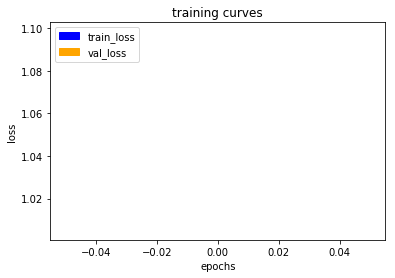

200/200 [==============================] - 143s - loss: 1.0978 - val_loss: 1.0053
Epoch 2/250
199/200 [============================>.] - ETA: 0s - loss: 0.8838

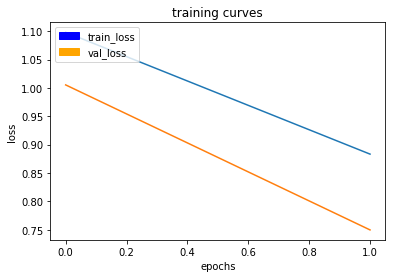

200/200 [==============================] - 140s - loss: 0.8832 - val_loss: 0.7497
Epoch 3/250
199/200 [============================>.] - ETA: 0s - loss: 0.6924

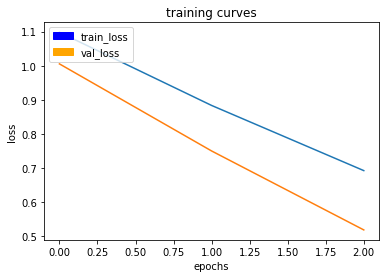

200/200 [==============================] - 140s - loss: 0.6920 - val_loss: 0.5180
Epoch 4/250
199/200 [============================>.] - ETA: 0s - loss: 0.5263

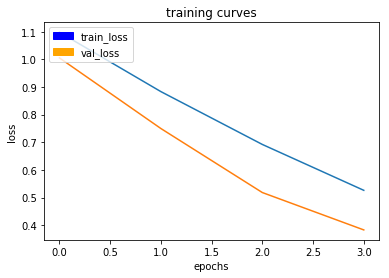

200/200 [==============================] - 140s - loss: 0.5260 - val_loss: 0.3827
Epoch 5/250
199/200 [============================>.] - ETA: 0s - loss: 0.3939

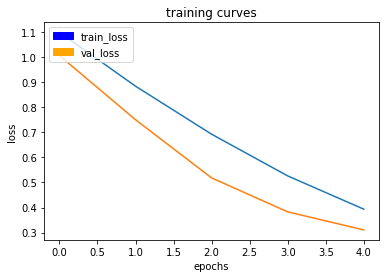

200/200 [==============================] - 140s - loss: 0.3936 - val_loss: 0.3109
Epoch 6/250
199/200 [============================>.] - ETA: 0s - loss: 0.2934

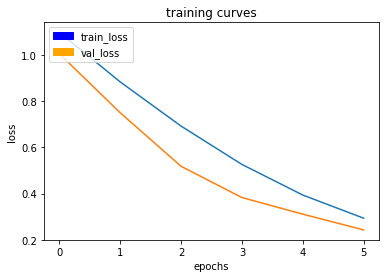

200/200 [==============================] - 140s - loss: 0.2931 - val_loss: 0.2426
Epoch 7/250
199/200 [============================>.] - ETA: 0s - loss: 0.2232

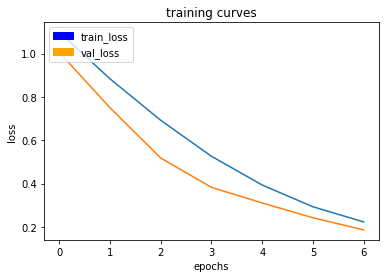

200/200 [==============================] - 140s - loss: 0.2231 - val_loss: 0.1864
Epoch 8/250
199/200 [============================>.] - ETA: 0s - loss: 0.1731

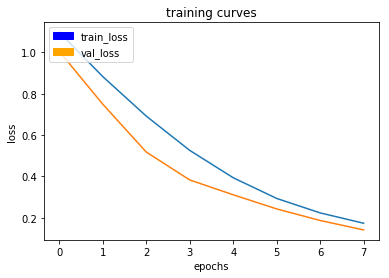

200/200 [==============================] - 141s - loss: 0.1730 - val_loss: 0.1408
Epoch 9/250
199/200 [============================>.] - ETA: 0s - loss: 0.1391

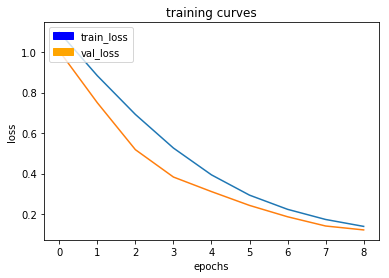

200/200 [==============================] - 141s - loss: 0.1391 - val_loss: 0.1215
Epoch 10/250
199/200 [============================>.] - ETA: 0s - loss: 0.1138

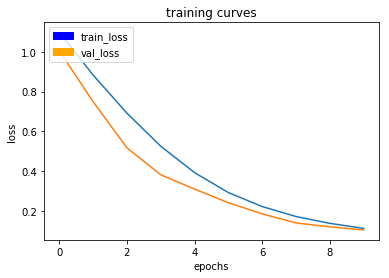

200/200 [==============================] - 141s - loss: 0.1137 - val_loss: 0.1059
Epoch 11/250
199/200 [============================>.] - ETA: 0s - loss: 0.0984

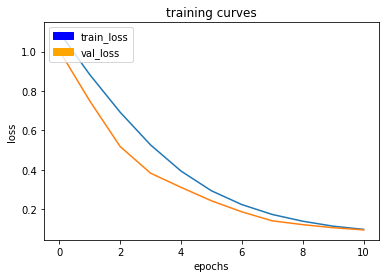

200/200 [==============================] - 141s - loss: 0.0983 - val_loss: 0.0948
Epoch 12/250
199/200 [============================>.] - ETA: 0s - loss: 0.0823

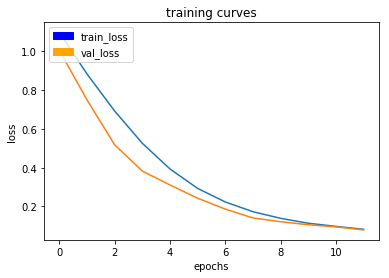

200/200 [==============================] - 138s - loss: 0.0824 - val_loss: 0.0792
Epoch 13/250
199/200 [============================>.] - ETA: 0s - loss: 0.0733

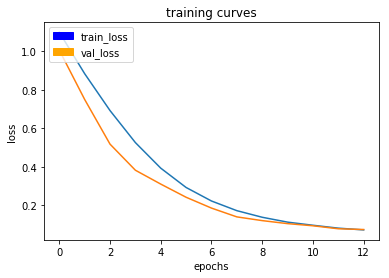

200/200 [==============================] - 136s - loss: 0.0733 - val_loss: 0.0753
Epoch 14/250
199/200 [============================>.] - ETA: 0s - loss: 0.0656

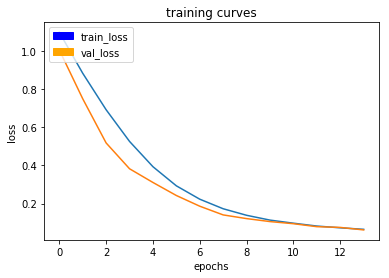

200/200 [==============================] - 136s - loss: 0.0655 - val_loss: 0.0622
Epoch 15/250
199/200 [============================>.] - ETA: 0s - loss: 0.0590

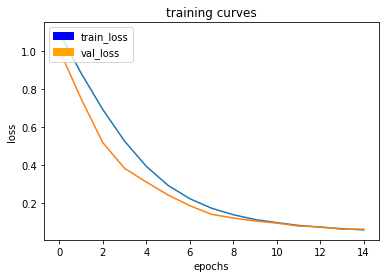

200/200 [==============================] - 136s - loss: 0.0590 - val_loss: 0.0629
Epoch 16/250
199/200 [============================>.] - ETA: 0s - loss: 0.0543

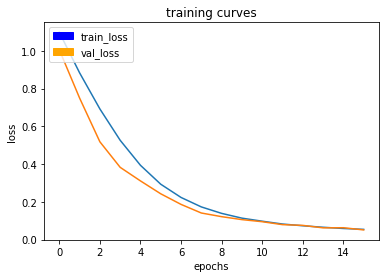

200/200 [==============================] - 136s - loss: 0.0542 - val_loss: 0.0513
Epoch 17/250
199/200 [============================>.] - ETA: 0s - loss: 0.0511

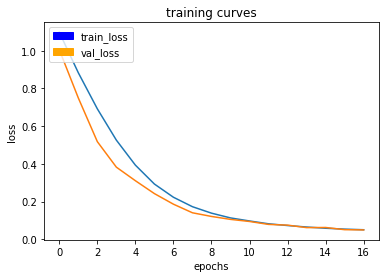

200/200 [==============================] - 136s - loss: 0.0511 - val_loss: 0.0500
Epoch 18/250
199/200 [============================>.] - ETA: 0s - loss: 0.0472

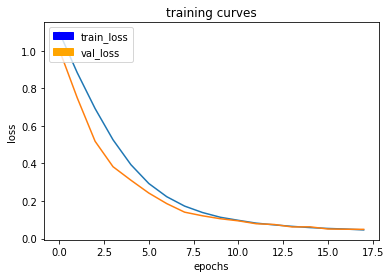

200/200 [==============================] - 136s - loss: 0.0472 - val_loss: 0.0495
Epoch 19/250
199/200 [============================>.] - ETA: 0s - loss: 0.0441

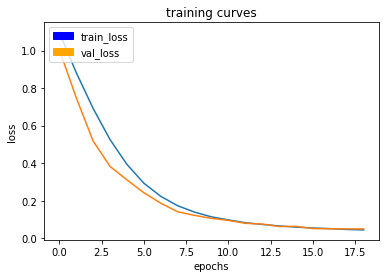

200/200 [==============================] - 136s - loss: 0.0440 - val_loss: 0.0495
Epoch 20/250
199/200 [============================>.] - ETA: 0s - loss: 0.0419

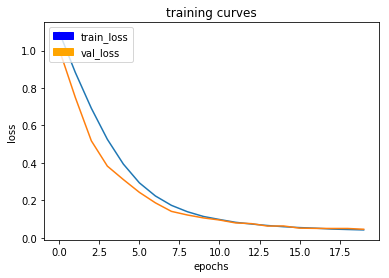

200/200 [==============================] - 135s - loss: 0.0418 - val_loss: 0.0454
Epoch 21/250
199/200 [============================>.] - ETA: 0s - loss: 0.0391

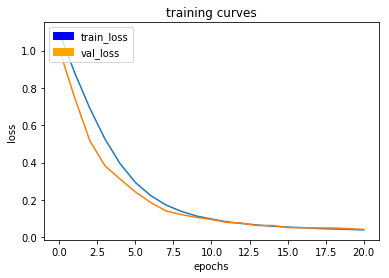

200/200 [==============================] - 136s - loss: 0.0391 - val_loss: 0.0421
Epoch 22/250
199/200 [============================>.] - ETA: 0s - loss: 0.0385

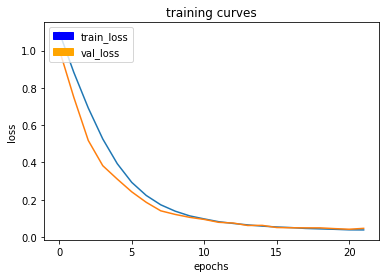

200/200 [==============================] - 136s - loss: 0.0385 - val_loss: 0.0469
Epoch 23/250
199/200 [============================>.] - ETA: 0s - loss: 0.0353

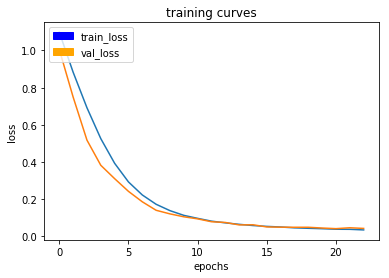

200/200 [==============================] - 136s - loss: 0.0352 - val_loss: 0.0434
Epoch 24/250
199/200 [============================>.] - ETA: 0s - loss: 0.0352

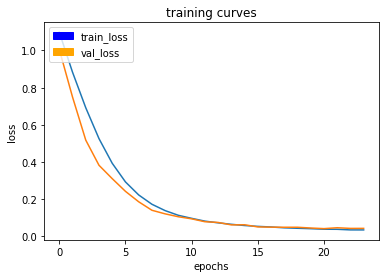

200/200 [==============================] - 137s - loss: 0.0352 - val_loss: 0.0435
Epoch 25/250
199/200 [============================>.] - ETA: 0s - loss: 0.0354

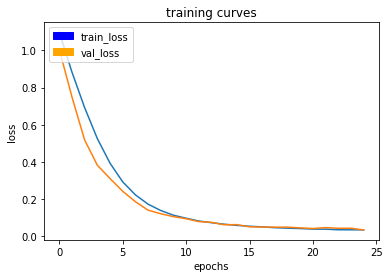

200/200 [==============================] - 136s - loss: 0.0354 - val_loss: 0.0345
Epoch 26/250
199/200 [============================>.] - ETA: 0s - loss: 0.0328

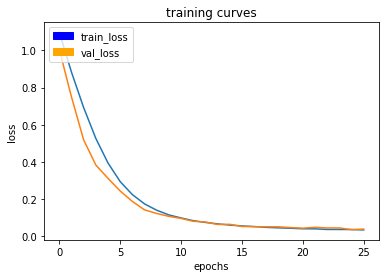

200/200 [==============================] - 136s - loss: 0.0328 - val_loss: 0.0371
Epoch 27/250
199/200 [============================>.] - ETA: 0s - loss: 0.0311

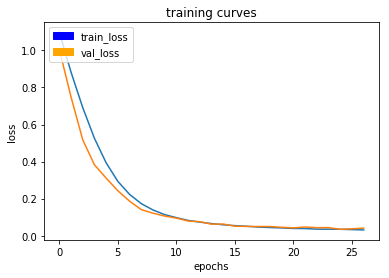

200/200 [==============================] - 136s - loss: 0.0311 - val_loss: 0.0408
Epoch 28/250
199/200 [============================>.] - ETA: 0s - loss: 0.0310

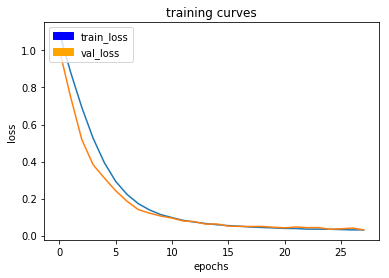

200/200 [==============================] - 137s - loss: 0.0310 - val_loss: 0.0314
Epoch 29/250
199/200 [============================>.] - ETA: 0s - loss: 0.0297

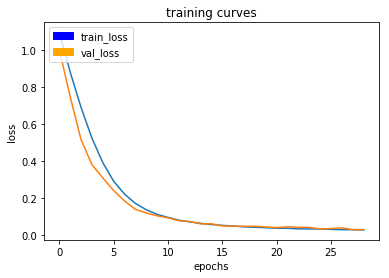

200/200 [==============================] - 136s - loss: 0.0297 - val_loss: 0.0314
Epoch 30/250
199/200 [============================>.] - ETA: 0s - loss: 0.0290

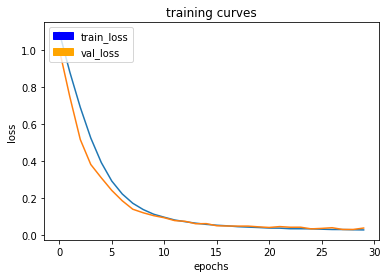

200/200 [==============================] - 136s - loss: 0.0290 - val_loss: 0.0390
Epoch 31/250
199/200 [============================>.] - ETA: 0s - loss: 0.0279

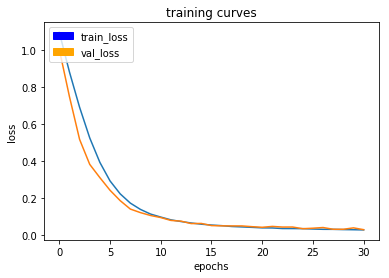

200/200 [==============================] - 136s - loss: 0.0279 - val_loss: 0.0292
Epoch 32/250
199/200 [============================>.] - ETA: 0s - loss: 0.0282

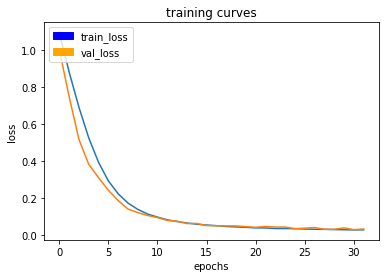

200/200 [==============================] - 136s - loss: 0.0282 - val_loss: 0.0328
Epoch 33/250
199/200 [============================>.] - ETA: 0s - loss: 0.0277

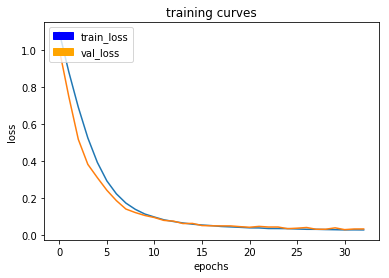

200/200 [==============================] - 137s - loss: 0.0277 - val_loss: 0.0330
Epoch 34/250
199/200 [============================>.] - ETA: 0s - loss: 0.0282

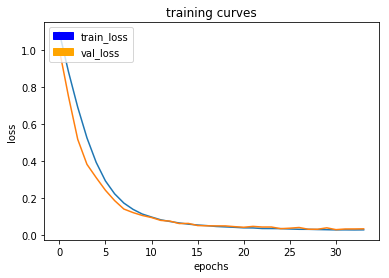

200/200 [==============================] - 136s - loss: 0.0281 - val_loss: 0.0336
Epoch 35/250
199/200 [============================>.] - ETA: 0s - loss: 0.0263

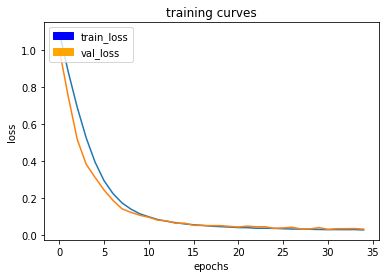

200/200 [==============================] - 136s - loss: 0.0263 - val_loss: 0.0305
Epoch 36/250
199/200 [============================>.] - ETA: 0s - loss: 0.0256

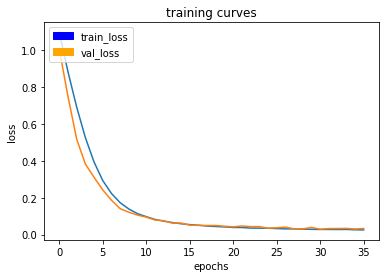

200/200 [==============================] - 136s - loss: 0.0255 - val_loss: 0.0331
Epoch 37/250
199/200 [============================>.] - ETA: 0s - loss: 0.0275

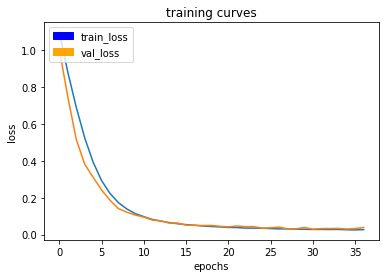

200/200 [==============================] - 136s - loss: 0.0275 - val_loss: 0.0385
Epoch 38/250
199/200 [============================>.] - ETA: 0s - loss: 0.0267

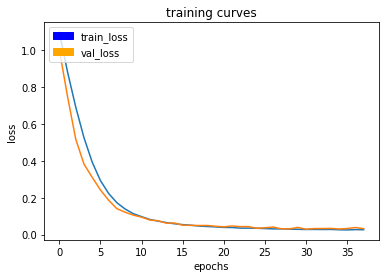

200/200 [==============================] - 136s - loss: 0.0267 - val_loss: 0.0323
Epoch 39/250
199/200 [============================>.] - ETA: 0s - loss: 0.0248

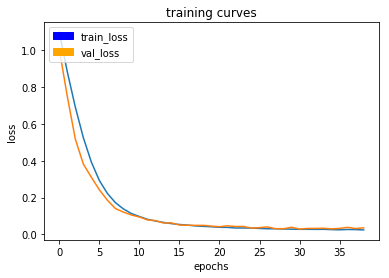

200/200 [==============================] - 136s - loss: 0.0247 - val_loss: 0.0361
Epoch 40/250
199/200 [============================>.] - ETA: 0s - loss: 0.0243

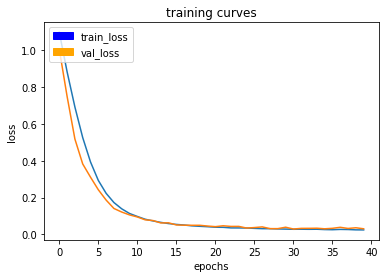

200/200 [==============================] - 135s - loss: 0.0243 - val_loss: 0.0306
Epoch 41/250
199/200 [============================>.] - ETA: 0s - loss: 0.0240

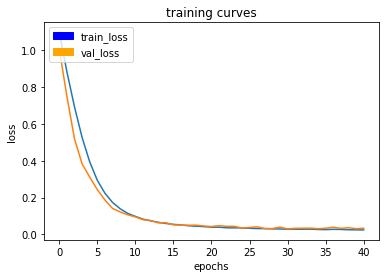

200/200 [==============================] - 136s - loss: 0.0240 - val_loss: 0.0329
Epoch 42/250
199/200 [============================>.] - ETA: 0s - loss: 0.0242

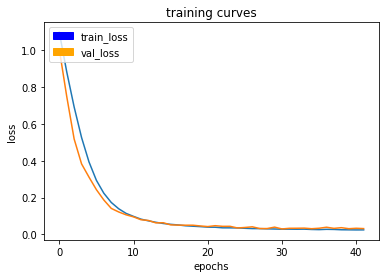

200/200 [==============================] - 136s - loss: 0.0241 - val_loss: 0.0311
Epoch 43/250
199/200 [============================>.] - ETA: 0s - loss: 0.0233

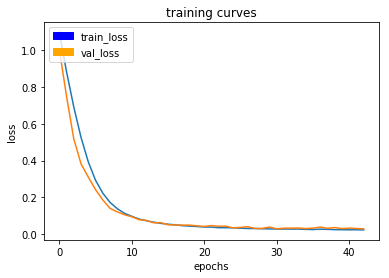

200/200 [==============================] - 137s - loss: 0.0233 - val_loss: 0.0293
Epoch 44/250
199/200 [============================>.] - ETA: 0s - loss: 0.0235

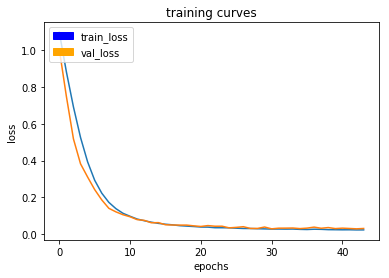

200/200 [==============================] - 136s - loss: 0.0234 - val_loss: 0.0312
Epoch 45/250
199/200 [============================>.] - ETA: 0s - loss: 0.0231

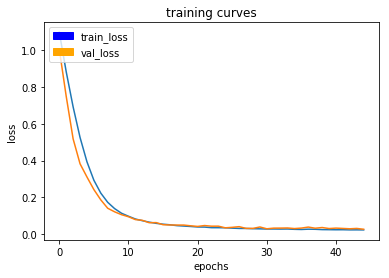

200/200 [==============================] - 136s - loss: 0.0231 - val_loss: 0.0267
Epoch 46/250
199/200 [============================>.] - ETA: 0s - loss: 0.0228

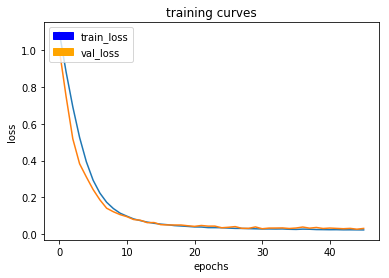

200/200 [==============================] - 136s - loss: 0.0228 - val_loss: 0.0309
Epoch 47/250
199/200 [============================>.] - ETA: 0s - loss: 0.0222

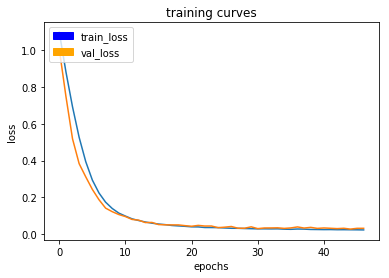

200/200 [==============================] - 137s - loss: 0.0222 - val_loss: 0.0309
Epoch 48/250
199/200 [============================>.] - ETA: 0s - loss: 0.0221

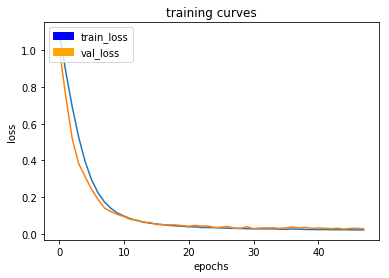

200/200 [==============================] - 137s - loss: 0.0221 - val_loss: 0.0284
Epoch 49/250
199/200 [============================>.] - ETA: 0s - loss: 0.0218

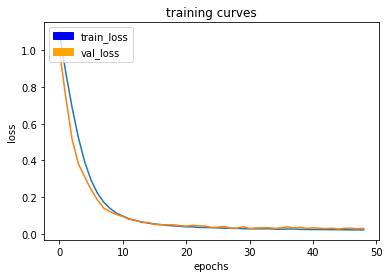

200/200 [==============================] - 136s - loss: 0.0218 - val_loss: 0.0302
Epoch 50/250
199/200 [============================>.] - ETA: 0s - loss: 0.0220

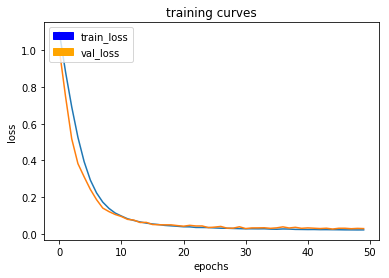

200/200 [==============================] - 136s - loss: 0.0220 - val_loss: 0.0291
Epoch 51/250
199/200 [============================>.] - ETA: 0s - loss: 0.0210

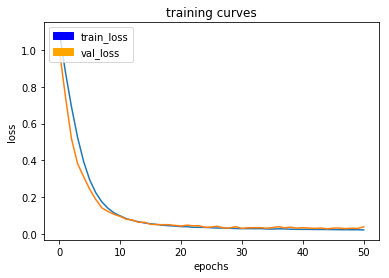

200/200 [==============================] - 137s - loss: 0.0210 - val_loss: 0.0377
Epoch 52/250
199/200 [============================>.] - ETA: 0s - loss: 0.0215

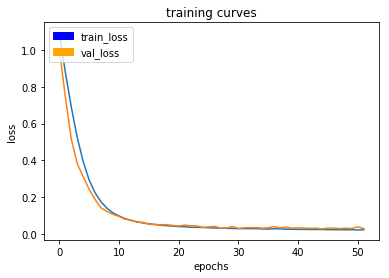

200/200 [==============================] - 136s - loss: 0.0215 - val_loss: 0.0287
Epoch 53/250
199/200 [============================>.] - ETA: 0s - loss: 0.0212

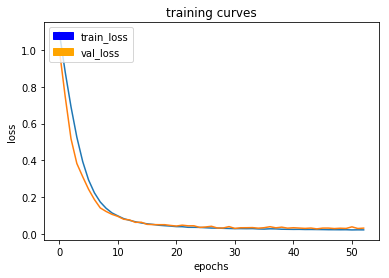

200/200 [==============================] - 136s - loss: 0.0212 - val_loss: 0.0307
Epoch 54/250
199/200 [============================>.] - ETA: 0s - loss: 0.0208

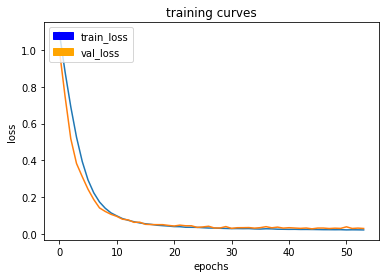

200/200 [==============================] - 136s - loss: 0.0208 - val_loss: 0.0286
Epoch 55/250
199/200 [============================>.] - ETA: 0s - loss: 0.0208

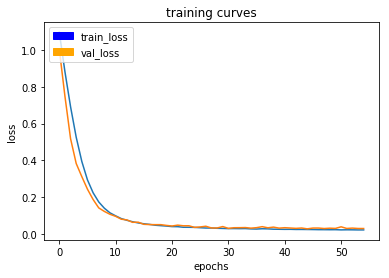

200/200 [==============================] - 137s - loss: 0.0208 - val_loss: 0.0284
Epoch 56/250
199/200 [============================>.] - ETA: 0s - loss: 0.0202

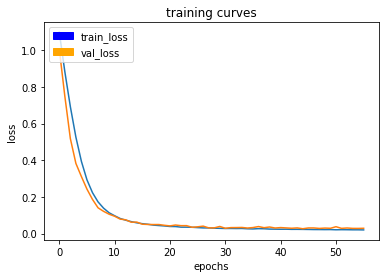

200/200 [==============================] - 136s - loss: 0.0202 - val_loss: 0.0291
Epoch 57/250
199/200 [============================>.] - ETA: 0s - loss: 0.0207

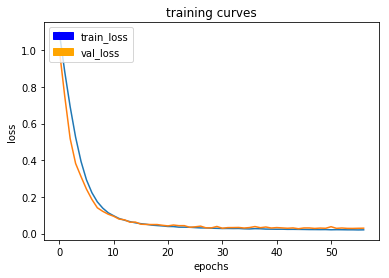

200/200 [==============================] - 137s - loss: 0.0207 - val_loss: 0.0296
Epoch 58/250
199/200 [============================>.] - ETA: 0s - loss: 0.0199

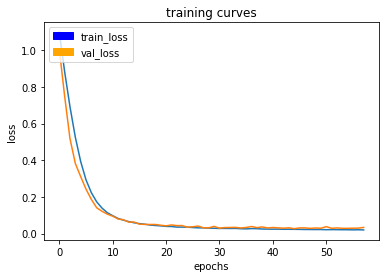

200/200 [==============================] - 136s - loss: 0.0198 - val_loss: 0.0334
Epoch 59/250
199/200 [============================>.] - ETA: 0s - loss: 0.0205

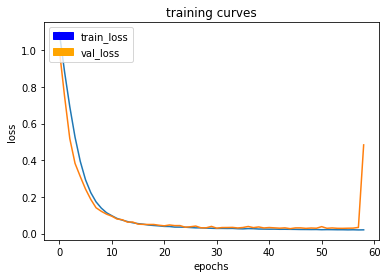

200/200 [==============================] - 135s - loss: 0.0205 - val_loss: 0.4836
Epoch 60/250
199/200 [============================>.] - ETA: 0s - loss: 0.0209

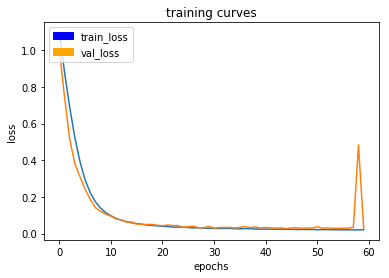

200/200 [==============================] - 136s - loss: 0.0209 - val_loss: 0.0295
Epoch 61/250
199/200 [============================>.] - ETA: 0s - loss: 0.0192

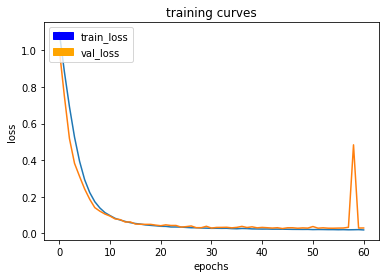

200/200 [==============================] - 136s - loss: 0.0192 - val_loss: 0.0297
Epoch 62/250
199/200 [============================>.] - ETA: 0s - loss: 0.0197

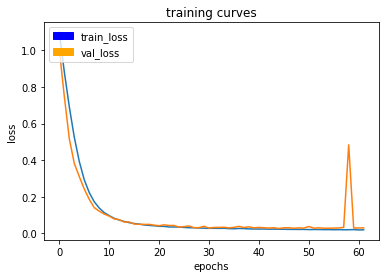

200/200 [==============================] - 136s - loss: 0.0197 - val_loss: 0.0303
Epoch 63/250
199/200 [============================>.] - ETA: 0s - loss: 0.0192

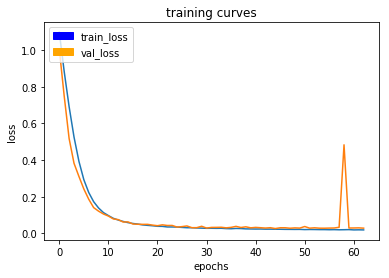

200/200 [==============================] - 136s - loss: 0.0191 - val_loss: 0.0287
Epoch 64/250
199/200 [============================>.] - ETA: 0s - loss: 0.0194

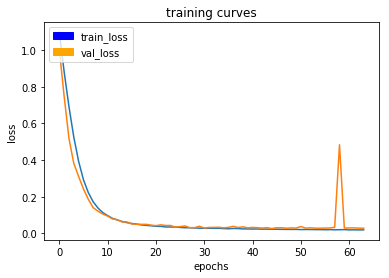

200/200 [==============================] - 136s - loss: 0.0194 - val_loss: 0.0286
Epoch 65/250
199/200 [============================>.] - ETA: 0s - loss: 0.0188

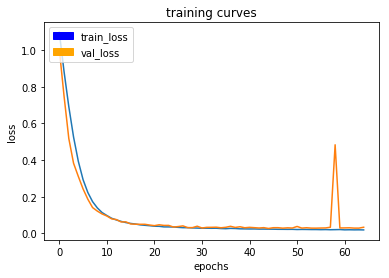

200/200 [==============================] - 137s - loss: 0.0188 - val_loss: 0.0334
Epoch 66/250
199/200 [============================>.] - ETA: 0s - loss: 0.0187

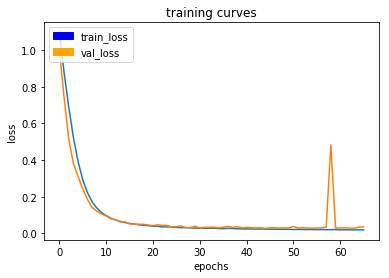

200/200 [==============================] - 136s - loss: 0.0187 - val_loss: 0.0358
Epoch 67/250
199/200 [============================>.] - ETA: 0s - loss: 0.0189

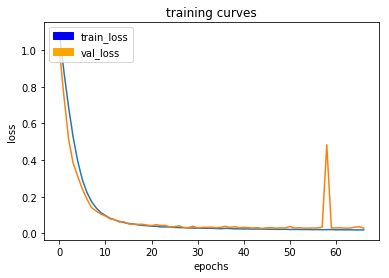

200/200 [==============================] - 136s - loss: 0.0189 - val_loss: 0.0285
Epoch 68/250
199/200 [============================>.] - ETA: 0s - loss: 0.0185

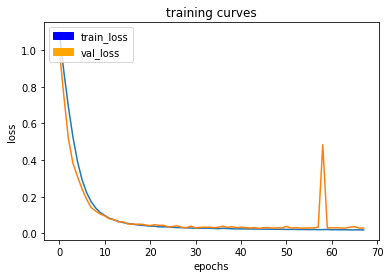

200/200 [==============================] - 136s - loss: 0.0185 - val_loss: 0.0289
Epoch 69/250
199/200 [============================>.] - ETA: 0s - loss: 0.0188

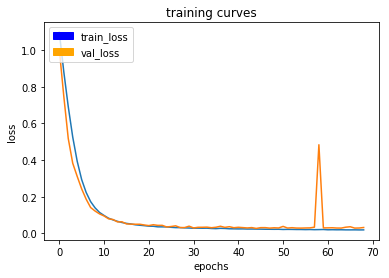

200/200 [==============================] - 136s - loss: 0.0187 - val_loss: 0.0317
Epoch 70/250
199/200 [============================>.] - ETA: 0s - loss: 0.0183

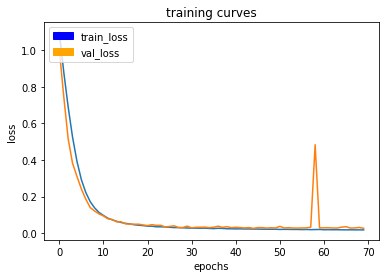

200/200 [==============================] - 136s - loss: 0.0183 - val_loss: 0.0271
Epoch 71/250
199/200 [============================>.] - ETA: 0s - loss: 0.0176

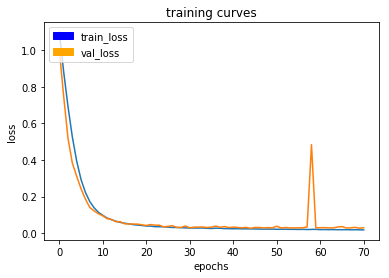

200/200 [==============================] - 136s - loss: 0.0176 - val_loss: 0.0295
Epoch 72/250
199/200 [============================>.] - ETA: 0s - loss: 0.0183

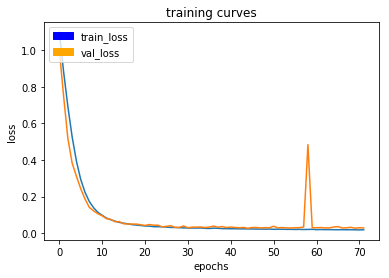

200/200 [==============================] - 136s - loss: 0.0183 - val_loss: 0.0285
Epoch 73/250
199/200 [============================>.] - ETA: 0s - loss: 0.0183

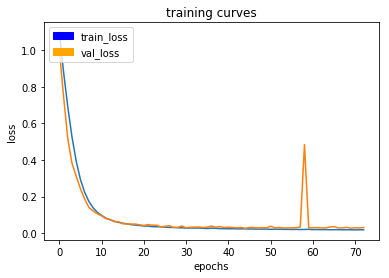

200/200 [==============================] - 136s - loss: 0.0183 - val_loss: 0.0310
Epoch 74/250
199/200 [============================>.] - ETA: 0s - loss: 0.0180

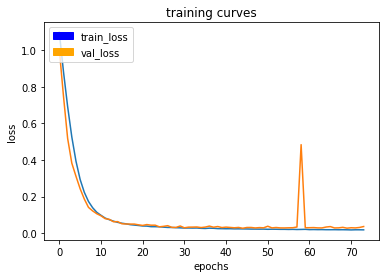

200/200 [==============================] - 136s - loss: 0.0180 - val_loss: 0.0361
Epoch 75/250
199/200 [============================>.] - ETA: 0s - loss: 0.0172

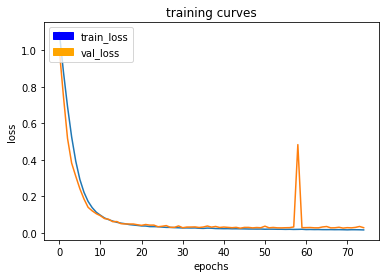

200/200 [==============================] - 136s - loss: 0.0172 - val_loss: 0.0294
Epoch 76/250
199/200 [============================>.] - ETA: 0s - loss: 0.0176

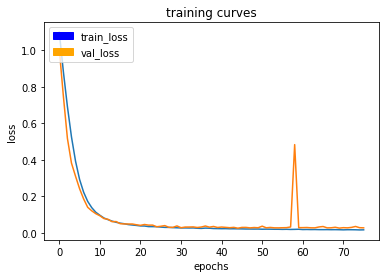

200/200 [==============================] - 136s - loss: 0.0176 - val_loss: 0.0286
Epoch 77/250
199/200 [============================>.] - ETA: 0s - loss: 0.0176

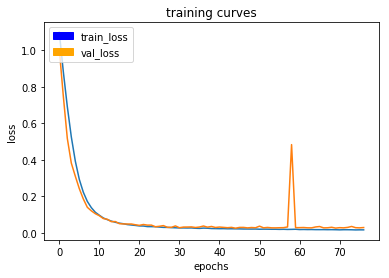

200/200 [==============================] - 136s - loss: 0.0175 - val_loss: 0.0302
Epoch 78/250
199/200 [============================>.] - ETA: 0s - loss: 0.0176

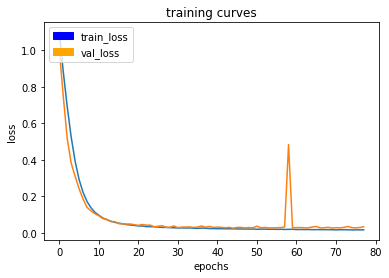

200/200 [==============================] - 136s - loss: 0.0176 - val_loss: 0.0349
Epoch 79/250
199/200 [============================>.] - ETA: 0s - loss: 0.0170

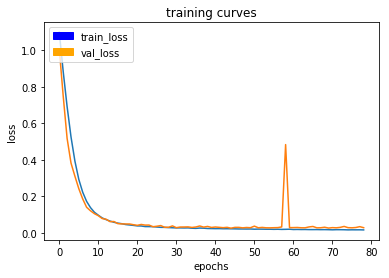

200/200 [==============================] - 136s - loss: 0.0170 - val_loss: 0.0292
Epoch 80/250
199/200 [============================>.] - ETA: 0s - loss: 0.0169

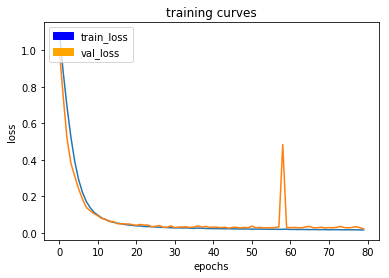

200/200 [==============================] - 136s - loss: 0.0169 - val_loss: 0.0224
Epoch 81/250
199/200 [============================>.] - ETA: 0s - loss: 0.0167

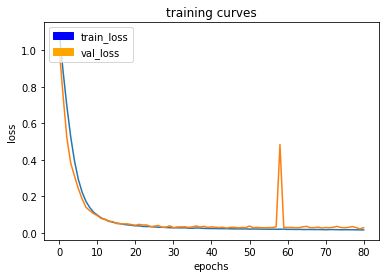

200/200 [==============================] - 136s - loss: 0.0167 - val_loss: 0.0287
Epoch 82/250
199/200 [============================>.] - ETA: 0s - loss: 0.0174

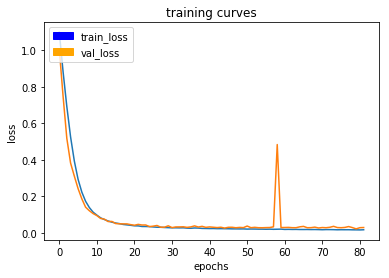

200/200 [==============================] - 135s - loss: 0.0174 - val_loss: 0.0296
Epoch 83/250
199/200 [============================>.] - ETA: 0s - loss: 0.0164

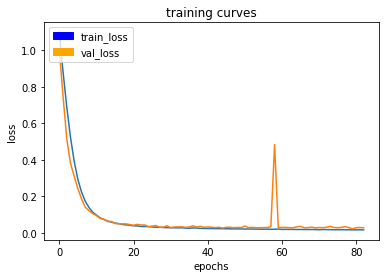

200/200 [==============================] - 134s - loss: 0.0164 - val_loss: 0.0280
Epoch 84/250
199/200 [============================>.] - ETA: 0s - loss: 0.0169

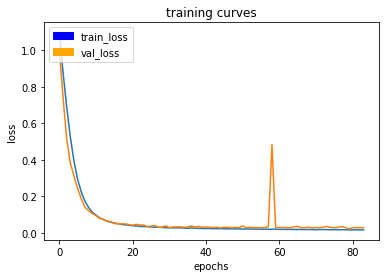

200/200 [==============================] - 135s - loss: 0.0168 - val_loss: 0.0292
Epoch 85/250
199/200 [============================>.] - ETA: 0s - loss: 0.0164

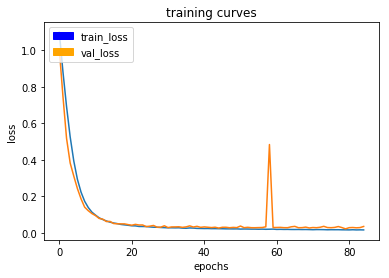

200/200 [==============================] - 136s - loss: 0.0164 - val_loss: 0.0353
Epoch 86/250
199/200 [============================>.] - ETA: 0s - loss: 0.0168

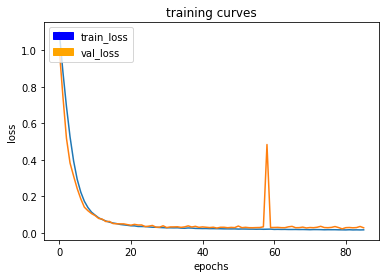

200/200 [==============================] - 136s - loss: 0.0168 - val_loss: 0.0281
Epoch 87/250
199/200 [============================>.] - ETA: 0s - loss: 0.0164

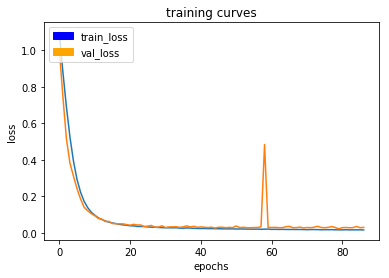

200/200 [==============================] - 136s - loss: 0.0164 - val_loss: 0.0304
Epoch 88/250
199/200 [============================>.] - ETA: 0s - loss: 0.0164

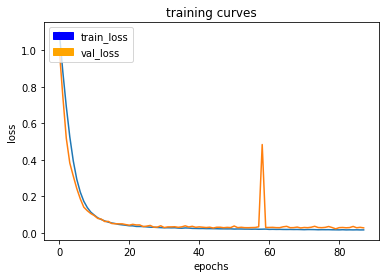

200/200 [==============================] - 135s - loss: 0.0164 - val_loss: 0.0276
Epoch 89/250
199/200 [============================>.] - ETA: 0s - loss: 0.0157

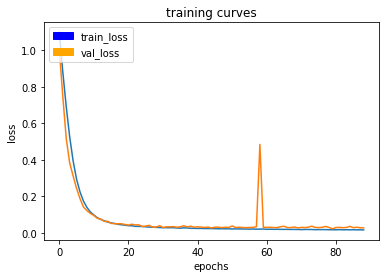

200/200 [==============================] - 136s - loss: 0.0158 - val_loss: 0.0271
Epoch 90/250
199/200 [============================>.] - ETA: 0s - loss: 0.0156

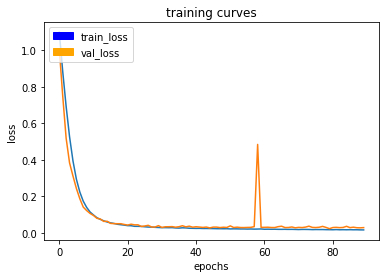

200/200 [==============================] - 136s - loss: 0.0156 - val_loss: 0.0282
Epoch 91/250
199/200 [============================>.] - ETA: 0s - loss: 0.0160

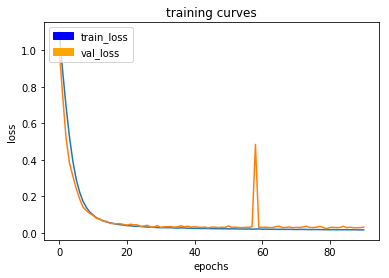

200/200 [==============================] - 136s - loss: 0.0159 - val_loss: 0.0305
Epoch 92/250
199/200 [============================>.] - ETA: 0s - loss: 0.0164

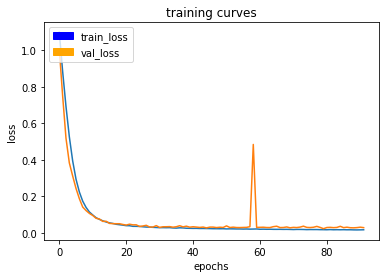

200/200 [==============================] - 136s - loss: 0.0164 - val_loss: 0.0280
Epoch 93/250
199/200 [============================>.] - ETA: 0s - loss: 0.0161

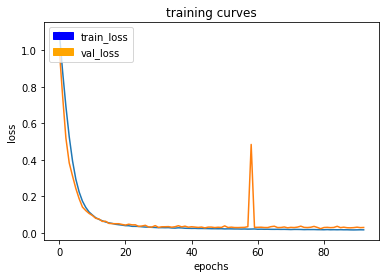

200/200 [==============================] - 135s - loss: 0.0160 - val_loss: 0.0289
Epoch 94/250
199/200 [============================>.] - ETA: 0s - loss: 0.0156

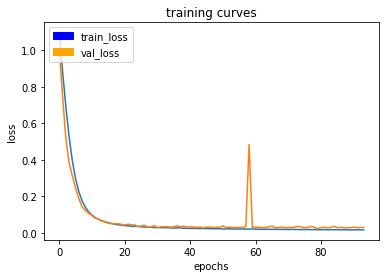

200/200 [==============================] - 137s - loss: 0.0156 - val_loss: 0.0295
Epoch 95/250
199/200 [============================>.] - ETA: 0s - loss: 0.0152

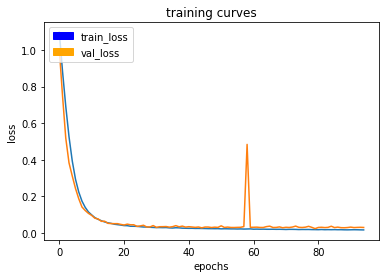

200/200 [==============================] - 136s - loss: 0.0152 - val_loss: 0.0286
Epoch 96/250
199/200 [============================>.] - ETA: 0s - loss: 0.0153

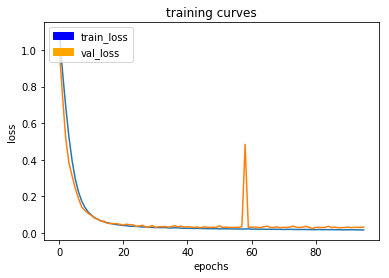

200/200 [==============================] - 135s - loss: 0.0153 - val_loss: 0.0303
Epoch 97/250
199/200 [============================>.] - ETA: 0s - loss: 0.0156

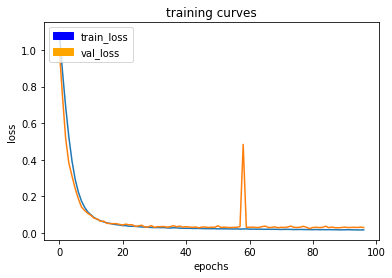

200/200 [==============================] - 136s - loss: 0.0156 - val_loss: 0.0283
Epoch 98/250
199/200 [============================>.] - ETA: 0s - loss: 0.0168

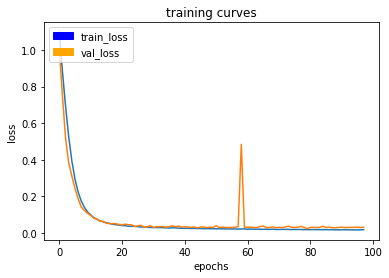

200/200 [==============================] - 136s - loss: 0.0168 - val_loss: 0.0296
Epoch 99/250
199/200 [============================>.] - ETA: 0s - loss: 0.0154

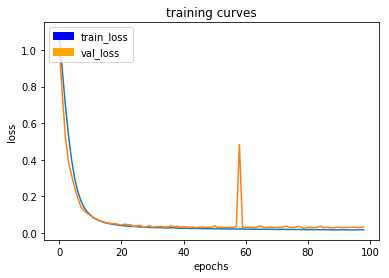

200/200 [==============================] - 136s - loss: 0.0154 - val_loss: 0.0313
Epoch 100/250
199/200 [============================>.] - ETA: 0s - loss: 0.0151

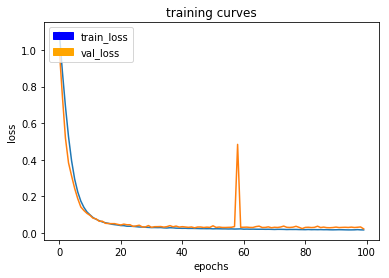

200/200 [==============================] - 136s - loss: 0.0151 - val_loss: 0.0208
Epoch 101/250
199/200 [============================>.] - ETA: 0s - loss: 0.0149

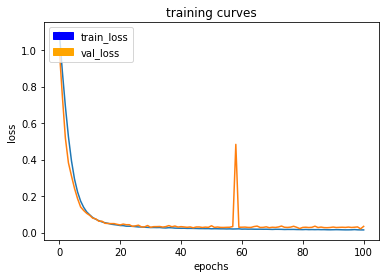

200/200 [==============================] - 137s - loss: 0.0149 - val_loss: 0.0343
Epoch 102/250
199/200 [============================>.] - ETA: 0s - loss: 0.0154

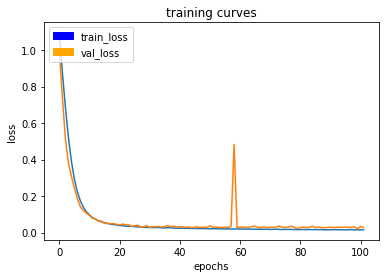

200/200 [==============================] - 136s - loss: 0.0154 - val_loss: 0.0276
Epoch 103/250
199/200 [============================>.] - ETA: 0s - loss: 0.0146

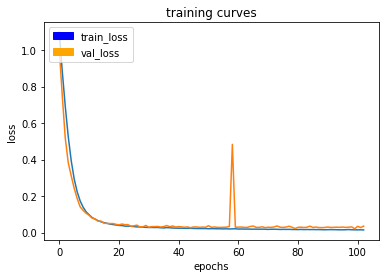

200/200 [==============================] - 135s - loss: 0.0146 - val_loss: 0.0355
Epoch 104/250
199/200 [============================>.] - ETA: 0s - loss: 0.0146

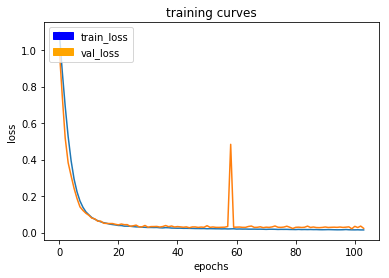

200/200 [==============================] - 136s - loss: 0.0146 - val_loss: 0.0232
Epoch 105/250
199/200 [============================>.] - ETA: 0s - loss: 0.0148

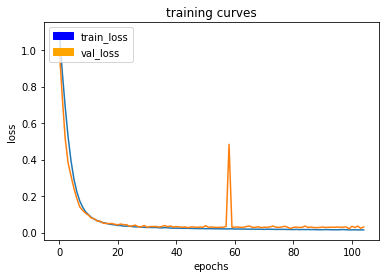

200/200 [==============================] - 136s - loss: 0.0149 - val_loss: 0.0310
Epoch 106/250
199/200 [============================>.] - ETA: 0s - loss: 0.0151

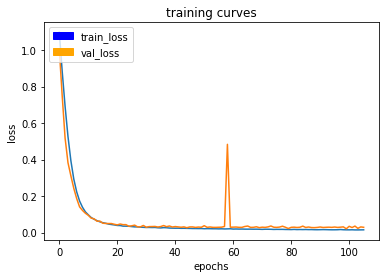

200/200 [==============================] - 136s - loss: 0.0151 - val_loss: 0.0289
Epoch 107/250
199/200 [============================>.] - ETA: 0s - loss: 0.0148

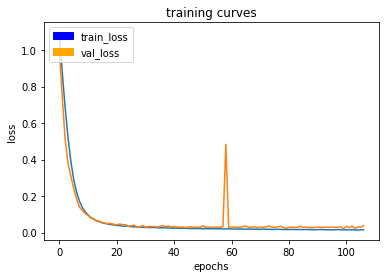

200/200 [==============================] - 121s - loss: 0.0148 - val_loss: 0.0383
Epoch 108/250
199/200 [============================>.] - ETA: 0s - loss: 0.0147

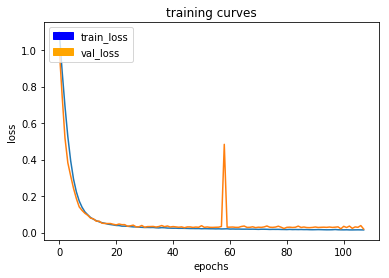

200/200 [==============================] - 120s - loss: 0.0147 - val_loss: 0.0193
Epoch 109/250
199/200 [============================>.] - ETA: 0s - loss: 0.0142

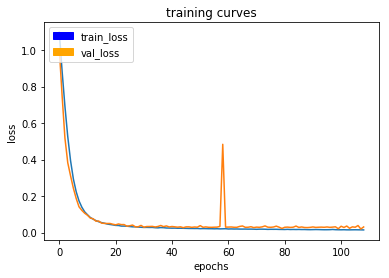

200/200 [==============================] - 120s - loss: 0.0142 - val_loss: 0.0305
Epoch 110/250
199/200 [============================>.] - ETA: 0s - loss: 0.0154

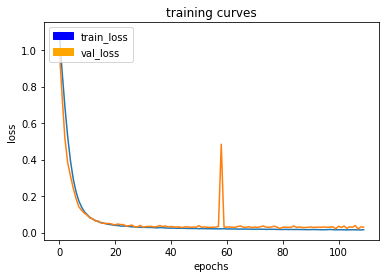

200/200 [==============================] - 120s - loss: 0.0154 - val_loss: 0.0295
Epoch 111/250
199/200 [============================>.] - ETA: 0s - loss: 0.0145

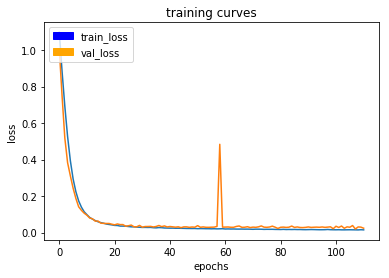

200/200 [==============================] - 120s - loss: 0.0145 - val_loss: 0.0235
Epoch 112/250
199/200 [============================>.] - ETA: 0s - loss: 0.0142

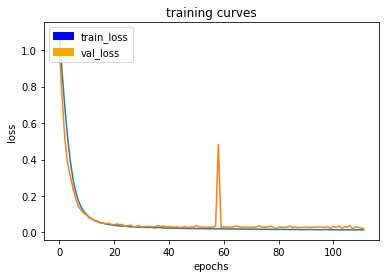

200/200 [==============================] - 126s - loss: 0.0141 - val_loss: 0.0222
Epoch 113/250
199/200 [============================>.] - ETA: 0s - loss: 0.0140

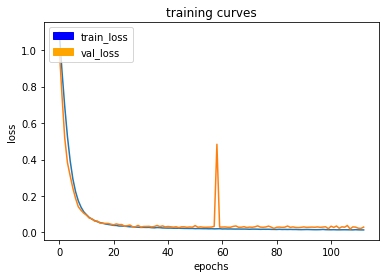

200/200 [==============================] - 136s - loss: 0.0140 - val_loss: 0.0295
Epoch 114/250
199/200 [============================>.] - ETA: 0s - loss: 0.0138

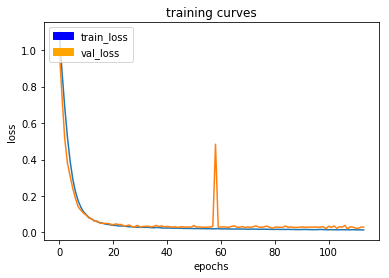

200/200 [==============================] - 136s - loss: 0.0138 - val_loss: 0.0294
Epoch 115/250
199/200 [============================>.] - ETA: 0s - loss: 0.0141

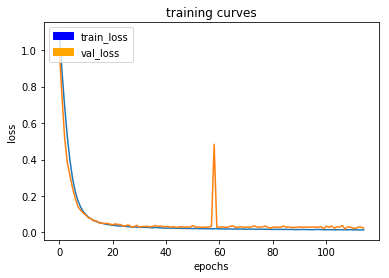

200/200 [==============================] - 136s - loss: 0.0141 - val_loss: 0.0238
Epoch 116/250
199/200 [============================>.] - ETA: 0s - loss: 0.0150

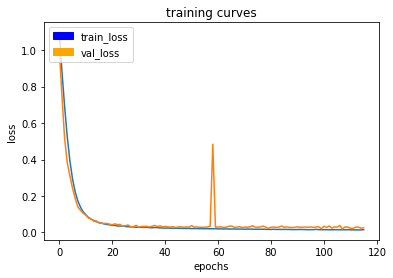

200/200 [==============================] - 124s - loss: 0.0150 - val_loss: 0.0258
Epoch 117/250
199/200 [============================>.] - ETA: 0s - loss: 0.0145

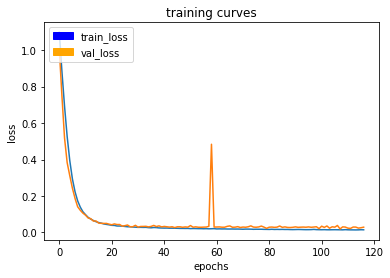

200/200 [==============================] - 121s - loss: 0.0145 - val_loss: 0.0289
Epoch 118/250
199/200 [============================>.] - ETA: 0s - loss: 0.0140

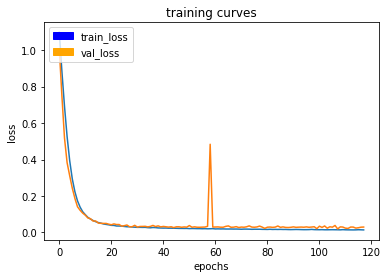

200/200 [==============================] - 120s - loss: 0.0139 - val_loss: 0.0295
Epoch 119/250
199/200 [============================>.] - ETA: 0s - loss: 0.0139

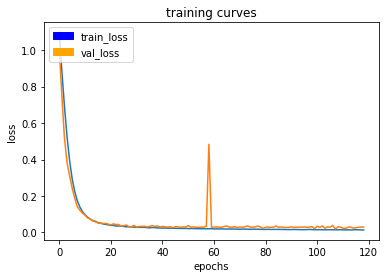

200/200 [==============================] - 121s - loss: 0.0139 - val_loss: 0.0293
Epoch 120/250
199/200 [============================>.] - ETA: 0s - loss: 0.0148

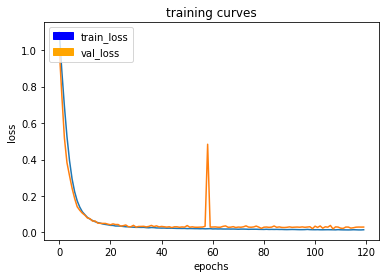

200/200 [==============================] - 121s - loss: 0.0148 - val_loss: 0.0295
Epoch 121/250
199/200 [============================>.] - ETA: 0s - loss: 0.0135

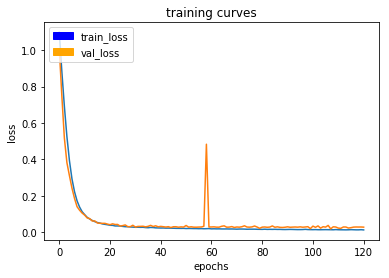

200/200 [==============================] - 120s - loss: 0.0135 - val_loss: 0.0286
Epoch 122/250
199/200 [============================>.] - ETA: 0s - loss: 0.0155

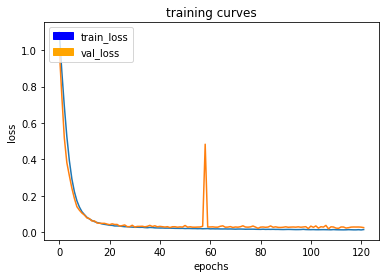

200/200 [==============================] - 121s - loss: 0.0155 - val_loss: 0.0262
Epoch 123/250
199/200 [============================>.] - ETA: 0s - loss: 0.0139

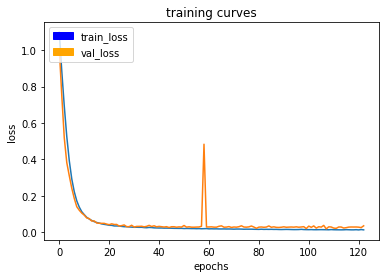

200/200 [==============================] - 120s - loss: 0.0139 - val_loss: 0.0359
Epoch 124/250
199/200 [============================>.] - ETA: 0s - loss: 0.0139

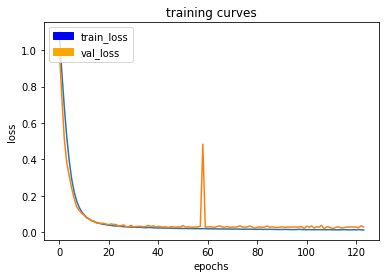

200/200 [==============================] - 121s - loss: 0.0140 - val_loss: 0.0291
Epoch 125/250
199/200 [============================>.] - ETA: 0s - loss: 0.0136

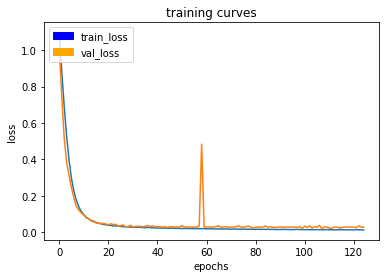

200/200 [==============================] - 121s - loss: 0.0136 - val_loss: 0.0282
Epoch 126/250
199/200 [============================>.] - ETA: 0s - loss: 0.0136

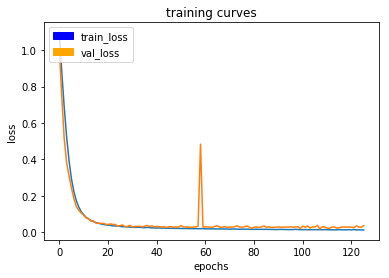

200/200 [==============================] - 121s - loss: 0.0136 - val_loss: 0.0364
Epoch 127/250
199/200 [============================>.] - ETA: 0s - loss: 0.0135

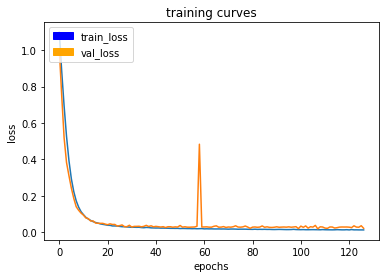

200/200 [==============================] - 120s - loss: 0.0135 - val_loss: 0.0224
Epoch 128/250
199/200 [============================>.] - ETA: 0s - loss: 0.0133

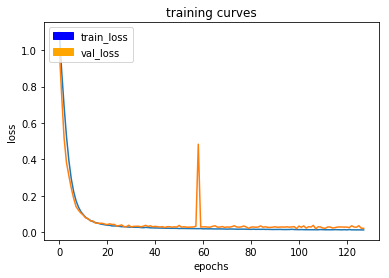

200/200 [==============================] - 121s - loss: 0.0133 - val_loss: 0.0222
Epoch 129/250
199/200 [============================>.] - ETA: 0s - loss: 0.0137

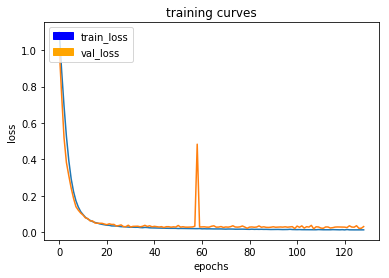

200/200 [==============================] - 120s - loss: 0.0137 - val_loss: 0.0316
Epoch 130/250
199/200 [============================>.] - ETA: 0s - loss: 0.0137

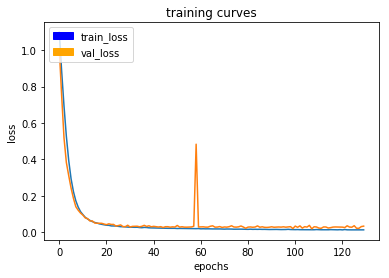

200/200 [==============================] - 121s - loss: 0.0137 - val_loss: 0.0340
Epoch 131/250
199/200 [============================>.] - ETA: 0s - loss: 0.0131

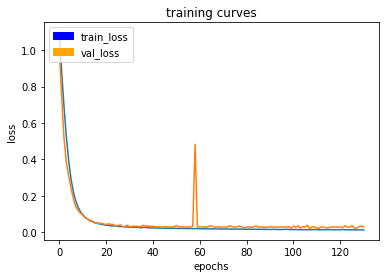

200/200 [==============================] - 120s - loss: 0.0131 - val_loss: 0.0294
Epoch 132/250
199/200 [============================>.] - ETA: 0s - loss: 0.0130

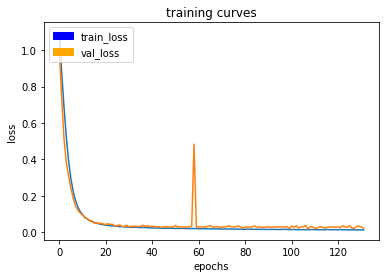

200/200 [==============================] - 120s - loss: 0.0130 - val_loss: 0.0226
Epoch 133/250
199/200 [============================>.] - ETA: 0s - loss: 0.0129

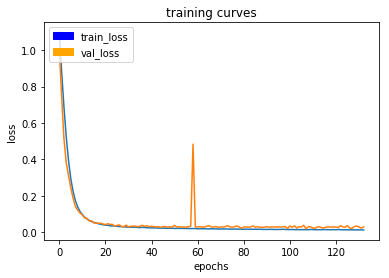

200/200 [==============================] - 121s - loss: 0.0129 - val_loss: 0.0298
Epoch 134/250
199/200 [============================>.] - ETA: 0s - loss: 0.0137

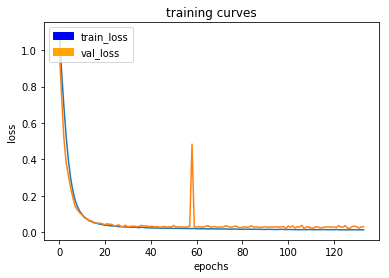

200/200 [==============================] - 120s - loss: 0.0137 - val_loss: 0.0309
Epoch 135/250
199/200 [============================>.] - ETA: 0s - loss: 0.0131

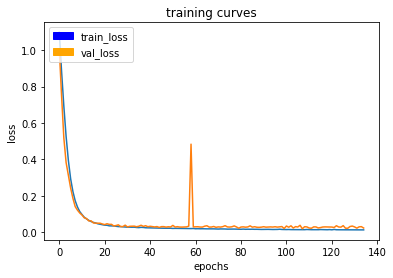

200/200 [==============================] - 121s - loss: 0.0131 - val_loss: 0.0232
Epoch 136/250
199/200 [============================>.] - ETA: 0s - loss: 0.0130

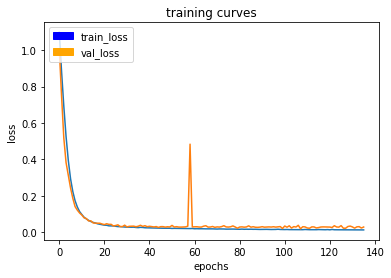

200/200 [==============================] - 120s - loss: 0.0130 - val_loss: 0.0289
Epoch 137/250
199/200 [============================>.] - ETA: 0s - loss: 0.0130

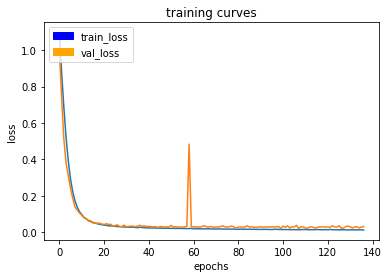

200/200 [==============================] - 120s - loss: 0.0130 - val_loss: 0.0310
Epoch 138/250
199/200 [============================>.] - ETA: 0s - loss: 0.0136

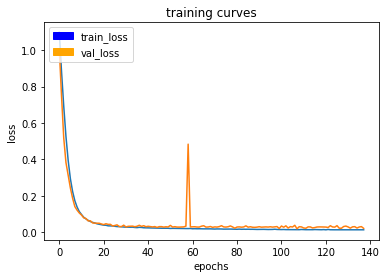

200/200 [==============================] - 121s - loss: 0.0136 - val_loss: 0.0215
Epoch 139/250
199/200 [============================>.] - ETA: 0s - loss: 0.0137

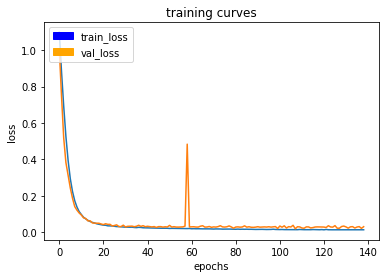

200/200 [==============================] - 121s - loss: 0.0137 - val_loss: 0.0306
Epoch 140/250
199/200 [============================>.] - ETA: 0s - loss: 0.0128

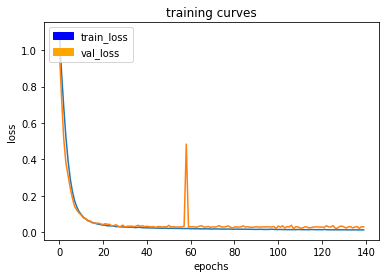

200/200 [==============================] - 121s - loss: 0.0128 - val_loss: 0.0299
Epoch 141/250
199/200 [============================>.] - ETA: 0s - loss: 0.0135

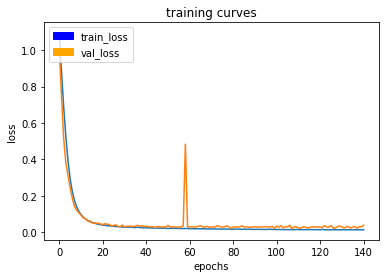

200/200 [==============================] - 121s - loss: 0.0135 - val_loss: 0.0385
Epoch 142/250
199/200 [============================>.] - ETA: 0s - loss: 0.0133

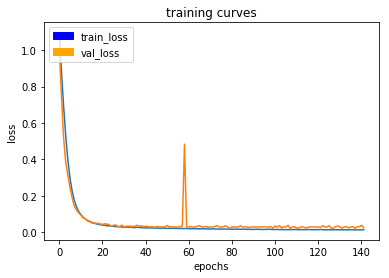

200/200 [==============================] - 120s - loss: 0.0133 - val_loss: 0.0237
Epoch 143/250
199/200 [============================>.] - ETA: 0s - loss: 0.0134

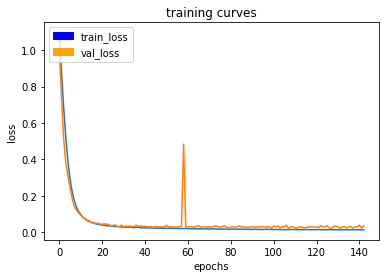

200/200 [==============================] - 120s - loss: 0.0134 - val_loss: 0.0358
Epoch 144/250
199/200 [============================>.] - ETA: 0s - loss: 0.0129

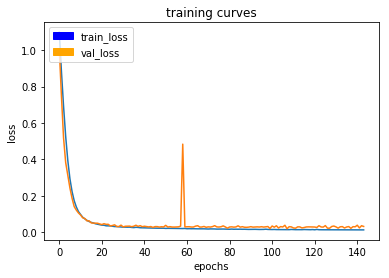

200/200 [==============================] - 120s - loss: 0.0129 - val_loss: 0.0318
Epoch 145/250
199/200 [============================>.] - ETA: 0s - loss: 0.0128

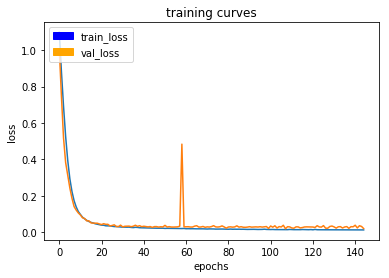

200/200 [==============================] - 121s - loss: 0.0128 - val_loss: 0.0202
Epoch 146/250
199/200 [============================>.] - ETA: 0s - loss: 0.0127

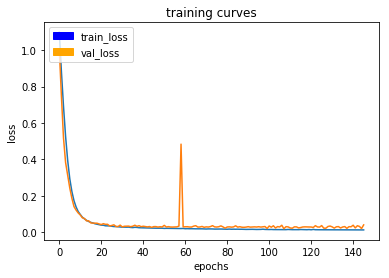

200/200 [==============================] - 120s - loss: 0.0127 - val_loss: 0.0402
Epoch 147/250
199/200 [============================>.] - ETA: 0s - loss: 0.0130

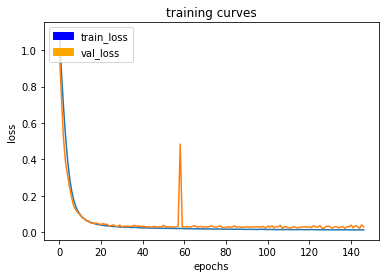

200/200 [==============================] - 120s - loss: 0.0130 - val_loss: 0.0290
Epoch 148/250
199/200 [============================>.] - ETA: 0s - loss: 0.0127

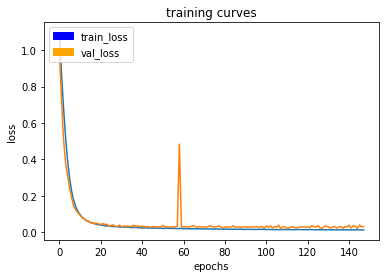

200/200 [==============================] - 120s - loss: 0.0127 - val_loss: 0.0315
Epoch 149/250
199/200 [============================>.] - ETA: 0s - loss: 0.0129

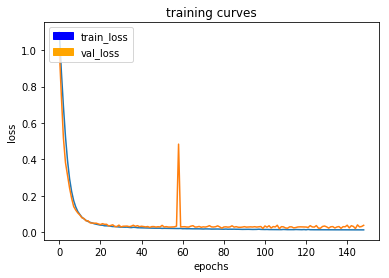

200/200 [==============================] - 121s - loss: 0.0129 - val_loss: 0.0379
Epoch 150/250
199/200 [============================>.] - ETA: 0s - loss: 0.0126

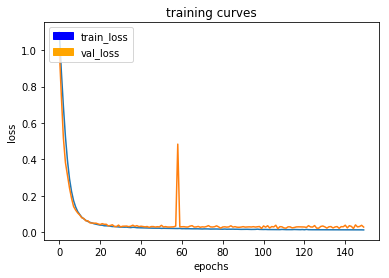

200/200 [==============================] - 120s - loss: 0.0126 - val_loss: 0.0281
Epoch 151/250
199/200 [============================>.] - ETA: 0s - loss: 0.0124

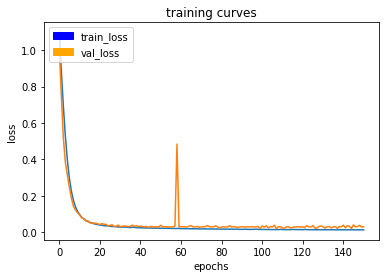

200/200 [==============================] - 120s - loss: 0.0124 - val_loss: 0.0300
Epoch 152/250
199/200 [============================>.] - ETA: 0s - loss: 0.0135

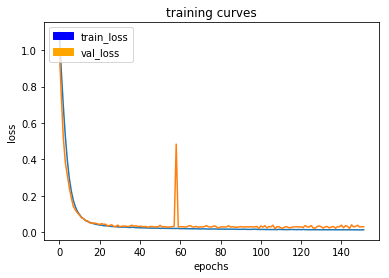

200/200 [==============================] - 120s - loss: 0.0135 - val_loss: 0.0300
Epoch 153/250
199/200 [============================>.] - ETA: 0s - loss: 0.0125

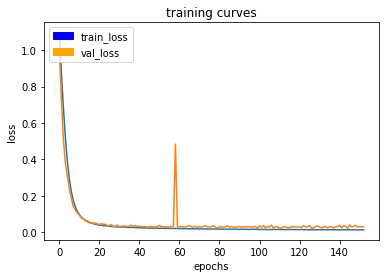

200/200 [==============================] - 120s - loss: 0.0125 - val_loss: 0.0284
Epoch 154/250
199/200 [============================>.] - ETA: 0s - loss: 0.0121

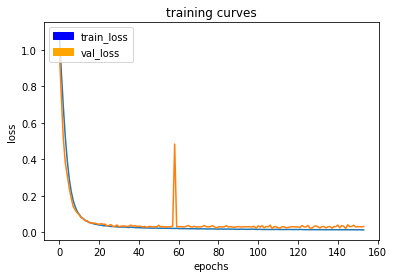

200/200 [==============================] - 121s - loss: 0.0121 - val_loss: 0.0307
Epoch 155/250
199/200 [============================>.] - ETA: 0s - loss: 0.0125

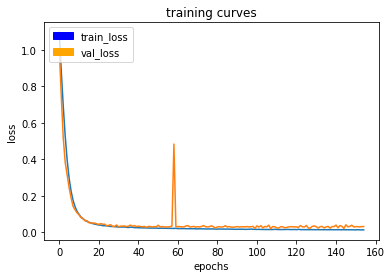

200/200 [==============================] - 120s - loss: 0.0125 - val_loss: 0.0304
Epoch 156/250
199/200 [============================>.] - ETA: 0s - loss: 0.0139

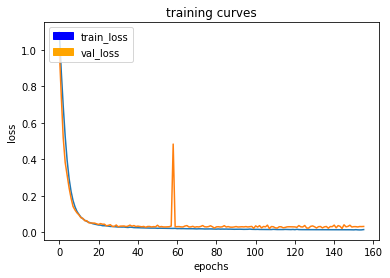

200/200 [==============================] - 121s - loss: 0.0139 - val_loss: 0.0311
Epoch 157/250
199/200 [============================>.] - ETA: 0s - loss: 0.0136

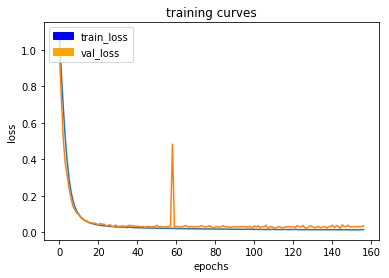

200/200 [==============================] - 120s - loss: 0.0136 - val_loss: 0.0353
Epoch 158/250
199/200 [============================>.] - ETA: 0s - loss: 0.0128

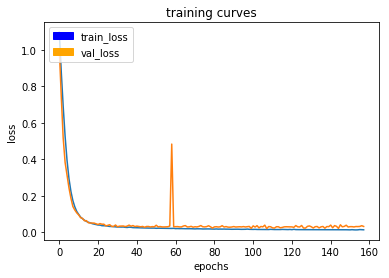

200/200 [==============================] - 120s - loss: 0.0127 - val_loss: 0.0311
Epoch 159/250
199/200 [============================>.] - ETA: 0s - loss: 0.0122

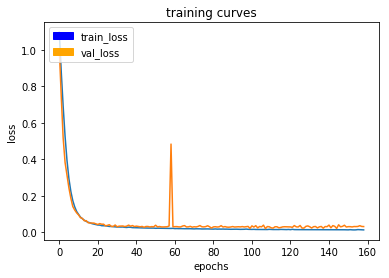

200/200 [==============================] - 121s - loss: 0.0122 - val_loss: 0.0305
Epoch 160/250
199/200 [============================>.] - ETA: 0s - loss: 0.0122

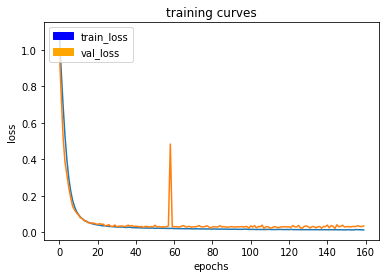

200/200 [==============================] - 121s - loss: 0.0122 - val_loss: 0.0342
Epoch 161/250
199/200 [============================>.] - ETA: 0s - loss: 0.0119

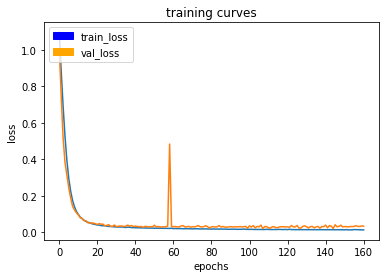

200/200 [==============================] - 121s - loss: 0.0120 - val_loss: 0.0320
Epoch 162/250
199/200 [============================>.] - ETA: 0s - loss: 0.0122

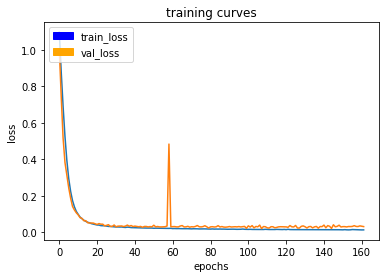

200/200 [==============================] - 120s - loss: 0.0122 - val_loss: 0.0302
Epoch 163/250
199/200 [============================>.] - ETA: 0s - loss: 0.0121

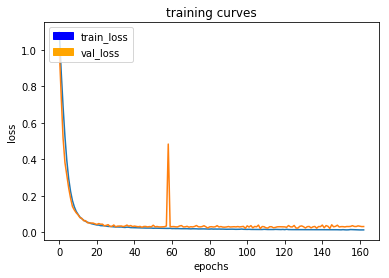

200/200 [==============================] - 121s - loss: 0.0121 - val_loss: 0.0305
Epoch 164/250
199/200 [============================>.] - ETA: 0s - loss: 0.0119

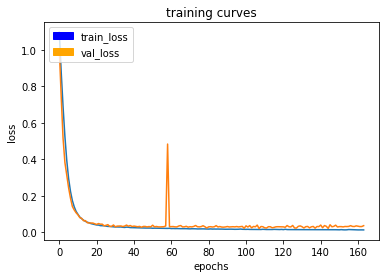

200/200 [==============================] - 121s - loss: 0.0119 - val_loss: 0.0352
Epoch 165/250
199/200 [============================>.] - ETA: 0s - loss: 0.0125

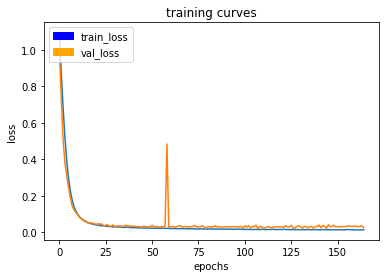

200/200 [==============================] - 121s - loss: 0.0125 - val_loss: 0.0241
Epoch 166/250
199/200 [============================>.] - ETA: 0s - loss: 0.0124

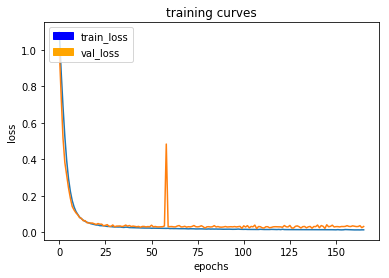

200/200 [==============================] - 120s - loss: 0.0124 - val_loss: 0.0306
Epoch 167/250
199/200 [============================>.] - ETA: 0s - loss: 0.0124

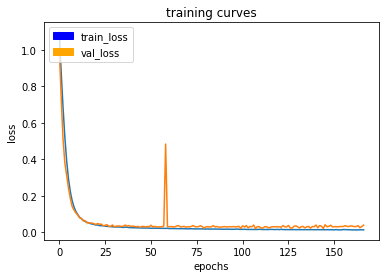

200/200 [==============================] - 120s - loss: 0.0124 - val_loss: 0.0383
Epoch 168/250
199/200 [============================>.] - ETA: 0s - loss: 0.0120

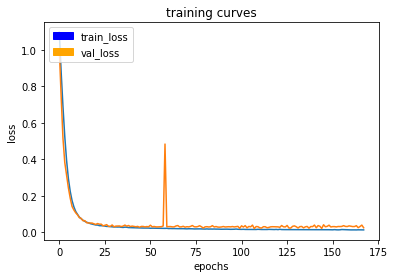

200/200 [==============================] - 120s - loss: 0.0120 - val_loss: 0.0237
Epoch 169/250
199/200 [============================>.] - ETA: 0s - loss: 0.0120

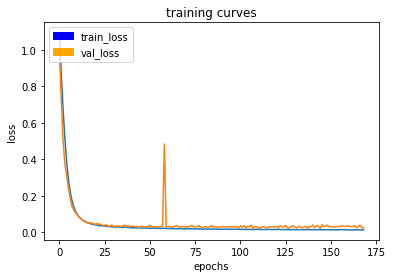

200/200 [==============================] - 121s - loss: 0.0120 - val_loss: 0.0234
Epoch 170/250
199/200 [============================>.] - ETA: 0s - loss: 0.0119

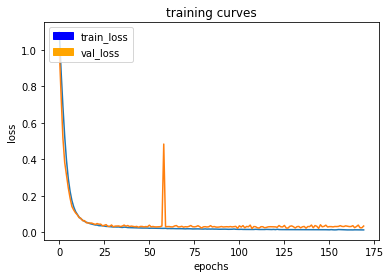

200/200 [==============================] - 121s - loss: 0.0119 - val_loss: 0.0332
Epoch 171/250
199/200 [============================>.] - ETA: 0s - loss: 0.0136

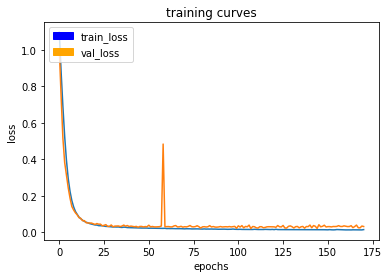

200/200 [==============================] - 120s - loss: 0.0136 - val_loss: 0.0305
Epoch 172/250
199/200 [============================>.] - ETA: 0s - loss: 0.0123

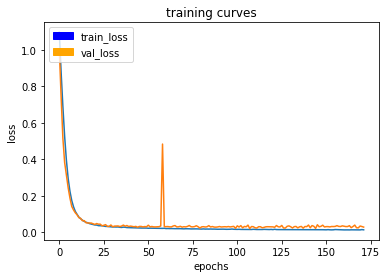

200/200 [==============================] - 120s - loss: 0.0123 - val_loss: 0.0273
Epoch 173/250
199/200 [============================>.] - ETA: 0s - loss: 0.0121

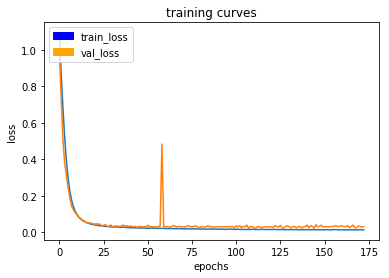

200/200 [==============================] - 121s - loss: 0.0121 - val_loss: 0.0301
Epoch 174/250
199/200 [============================>.] - ETA: 0s - loss: 0.0119

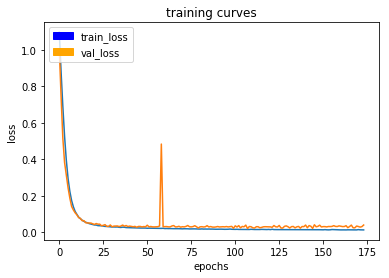

200/200 [==============================] - 121s - loss: 0.0119 - val_loss: 0.0387
Epoch 175/250
199/200 [============================>.] - ETA: 0s - loss: 0.0119

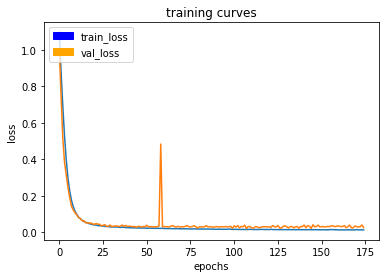

200/200 [==============================] - 120s - loss: 0.0120 - val_loss: 0.0245
Epoch 176/250
199/200 [============================>.] - ETA: 0s - loss: 0.0120

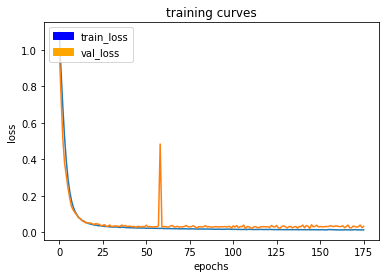

200/200 [==============================] - 120s - loss: 0.0120 - val_loss: 0.0310
Epoch 177/250
199/200 [============================>.] - ETA: 0s - loss: 0.0129

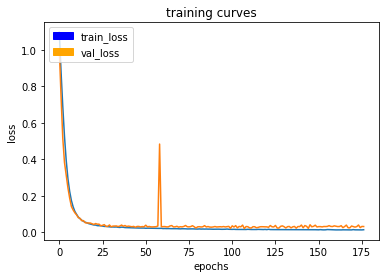

200/200 [==============================] - 120s - loss: 0.0129 - val_loss: 0.0305
Epoch 178/250
199/200 [============================>.] - ETA: 0s - loss: 0.0121

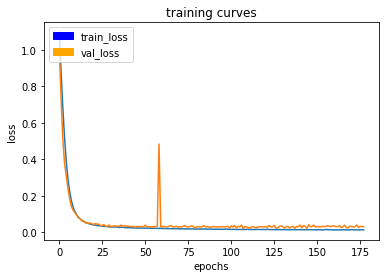

200/200 [==============================] - 120s - loss: 0.0121 - val_loss: 0.0295
Epoch 179/250
199/200 [============================>.] - ETA: 0s - loss: 0.0117

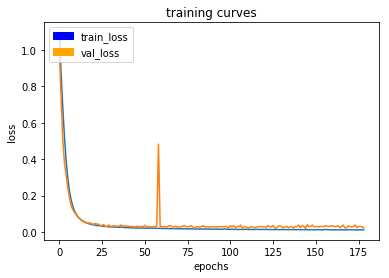

200/200 [==============================] - 121s - loss: 0.0117 - val_loss: 0.0224
Epoch 180/250
199/200 [============================>.] - ETA: 0s - loss: 0.0115

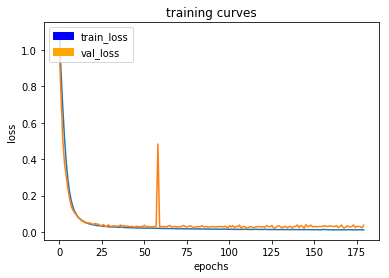

200/200 [==============================] - 120s - loss: 0.0115 - val_loss: 0.0377
Epoch 181/250
199/200 [============================>.] - ETA: 0s - loss: 0.0116

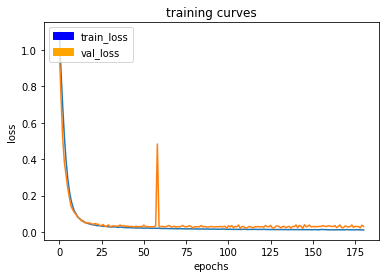

200/200 [==============================] - 120s - loss: 0.0115 - val_loss: 0.0307
Epoch 182/250
199/200 [============================>.] - ETA: 0s - loss: 0.0114

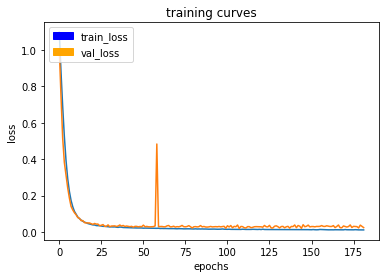

200/200 [==============================] - 121s - loss: 0.0114 - val_loss: 0.0242
Epoch 183/250
199/200 [============================>.] - ETA: 0s - loss: 0.0119

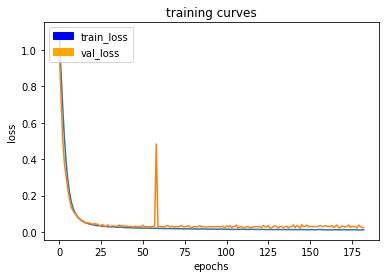

200/200 [==============================] - 121s - loss: 0.0119 - val_loss: 0.0239
Epoch 184/250
199/200 [============================>.] - ETA: 0s - loss: 0.0116

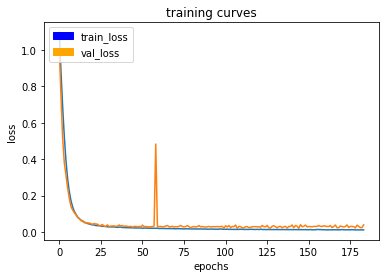

200/200 [==============================] - 120s - loss: 0.0115 - val_loss: 0.0396
Epoch 185/250
199/200 [============================>.] - ETA: 0s - loss: 0.0115

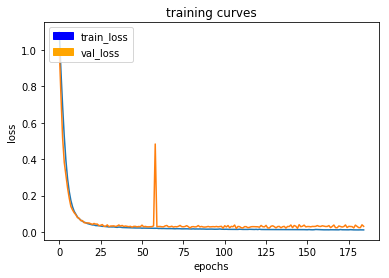

200/200 [==============================] - 120s - loss: 0.0115 - val_loss: 0.0311
Epoch 186/250
199/200 [============================>.] - ETA: 0s - loss: 0.0115

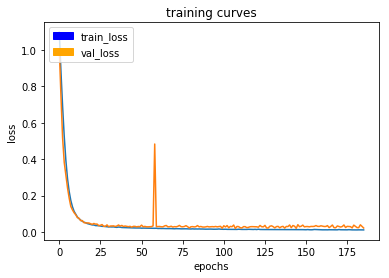

200/200 [==============================] - 120s - loss: 0.0115 - val_loss: 0.0220
Epoch 187/250
199/200 [============================>.] - ETA: 0s - loss: 0.0118

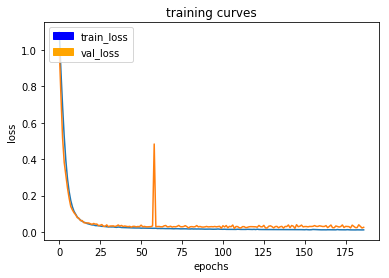

200/200 [==============================] - 120s - loss: 0.0117 - val_loss: 0.0258
Epoch 188/250
199/200 [============================>.] - ETA: 0s - loss: 0.0132

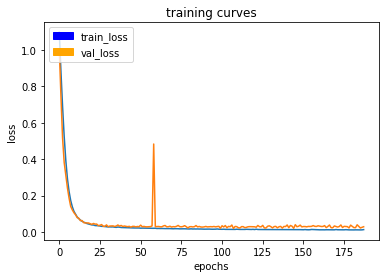

200/200 [==============================] - 120s - loss: 0.0132 - val_loss: 0.0289
Epoch 189/250
199/200 [============================>.] - ETA: 0s - loss: 0.0127

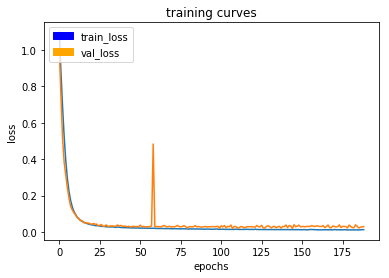

200/200 [==============================] - 120s - loss: 0.0127 - val_loss: 0.0294
Epoch 190/250
199/200 [============================>.] - ETA: 0s - loss: 0.0123

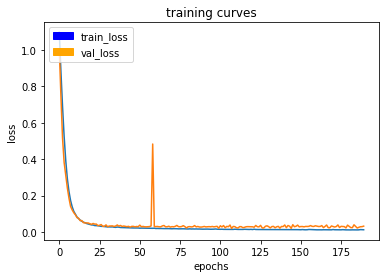

200/200 [==============================] - 120s - loss: 0.0123 - val_loss: 0.0321
Epoch 191/250
199/200 [============================>.] - ETA: 0s - loss: 0.0113

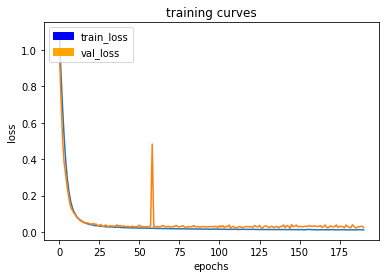

200/200 [==============================] - 120s - loss: 0.0113 - val_loss: 0.0238
Epoch 192/250
199/200 [============================>.] - ETA: 0s - loss: 0.0113

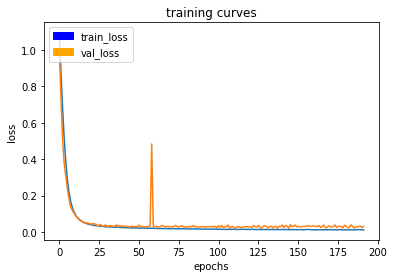

200/200 [==============================] - 121s - loss: 0.0113 - val_loss: 0.0311
Epoch 193/250
199/200 [============================>.] - ETA: 0s - loss: 0.0115

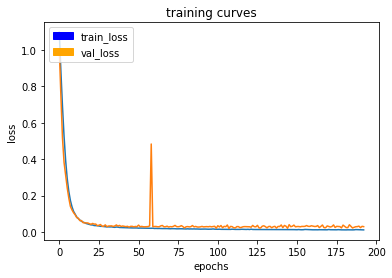

200/200 [==============================] - 121s - loss: 0.0115 - val_loss: 0.0292
Epoch 194/250
199/200 [============================>.] - ETA: 0s - loss: 0.0112

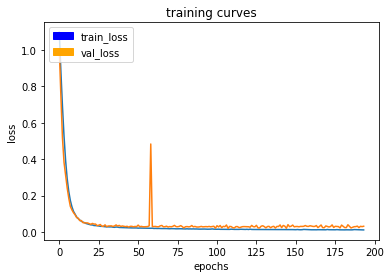

200/200 [==============================] - 120s - loss: 0.0112 - val_loss: 0.0313
Epoch 195/250
199/200 [============================>.] - ETA: 0s - loss: 0.0117

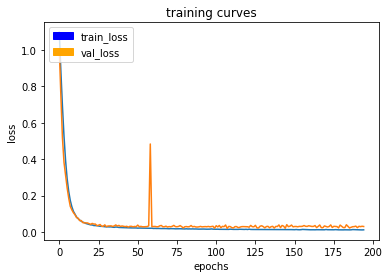

200/200 [==============================] - 120s - loss: 0.0117 - val_loss: 0.0299
Epoch 196/250
199/200 [============================>.] - ETA: 0s - loss: 0.0115

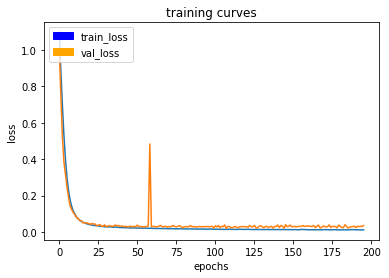

200/200 [==============================] - 120s - loss: 0.0115 - val_loss: 0.0352
Epoch 197/250
199/200 [============================>.] - ETA: 0s - loss: 0.0119

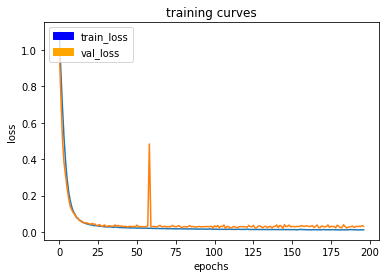

200/200 [==============================] - 120s - loss: 0.0120 - val_loss: 0.0308
Epoch 198/250
199/200 [============================>.] - ETA: 0s - loss: 0.0123

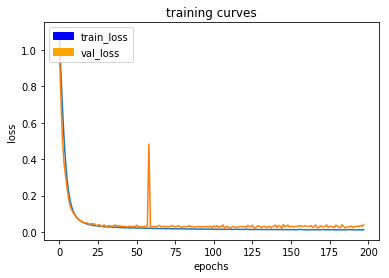

200/200 [==============================] - 121s - loss: 0.0123 - val_loss: 0.0404
Epoch 199/250
199/200 [============================>.] - ETA: 0s - loss: 0.0116

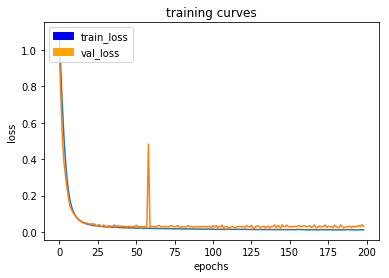

200/200 [==============================] - 121s - loss: 0.0116 - val_loss: 0.0302
Epoch 200/250
199/200 [============================>.] - ETA: 0s - loss: 0.0113

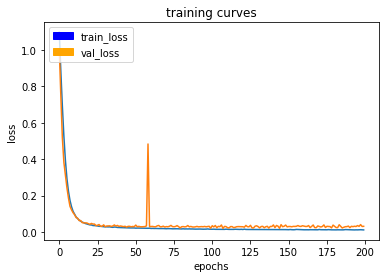

200/200 [==============================] - 120s - loss: 0.0113 - val_loss: 0.0310
Epoch 201/250
199/200 [============================>.] - ETA: 0s - loss: 0.0112

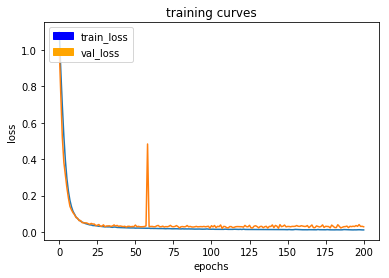

200/200 [==============================] - 120s - loss: 0.0112 - val_loss: 0.0284
Epoch 202/250
199/200 [============================>.] - ETA: 0s - loss: 0.0111

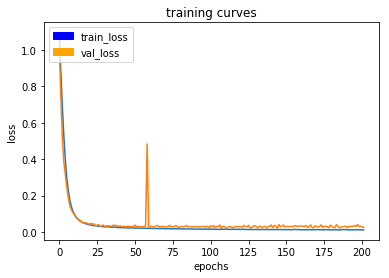

200/200 [==============================] - 121s - loss: 0.0111 - val_loss: 0.0241
Epoch 203/250
199/200 [============================>.] - ETA: 0s - loss: 0.0113

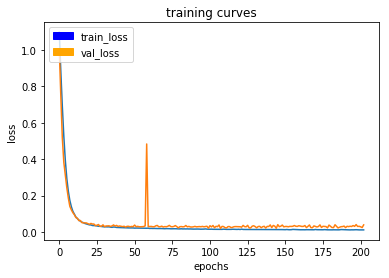

200/200 [==============================] - 121s - loss: 0.0113 - val_loss: 0.0387
Epoch 204/250
199/200 [============================>.] - ETA: 0s - loss: 0.0111

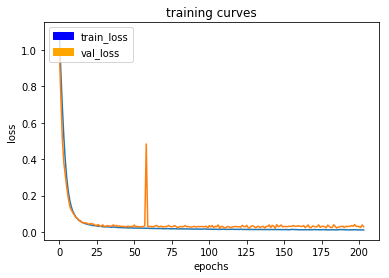

200/200 [==============================] - 120s - loss: 0.0111 - val_loss: 0.0291
Epoch 205/250
199/200 [============================>.] - ETA: 0s - loss: 0.0111

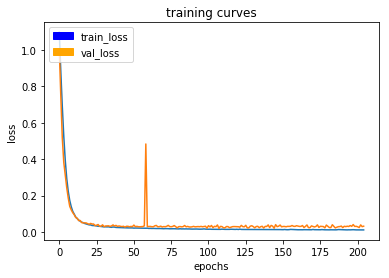

200/200 [==============================] - 120s - loss: 0.0111 - val_loss: 0.0315
Epoch 206/250
199/200 [============================>.] - ETA: 0s - loss: 0.0114

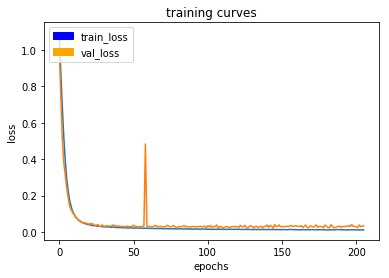

200/200 [==============================] - 120s - loss: 0.0114 - val_loss: 0.0338
Epoch 207/250
199/200 [============================>.] - ETA: 0s - loss: 0.0110

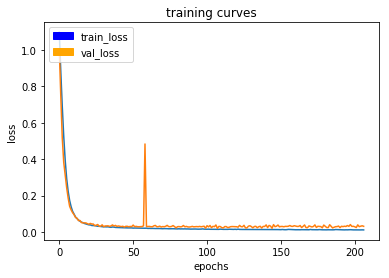

200/200 [==============================] - 120s - loss: 0.0110 - val_loss: 0.0308
Epoch 208/250
199/200 [============================>.] - ETA: 0s - loss: 0.0110

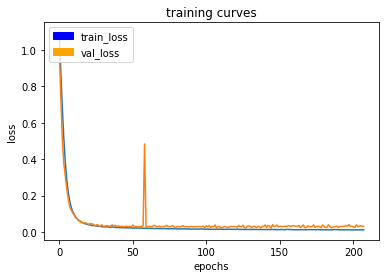

200/200 [==============================] - 121s - loss: 0.0110 - val_loss: 0.0313
Epoch 209/250
199/200 [============================>.] - ETA: 0s - loss: 0.0110

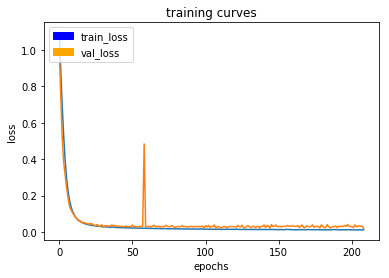

200/200 [==============================] - 120s - loss: 0.0110 - val_loss: 0.0193
Epoch 210/250
199/200 [============================>.] - ETA: 0s - loss: 0.0124

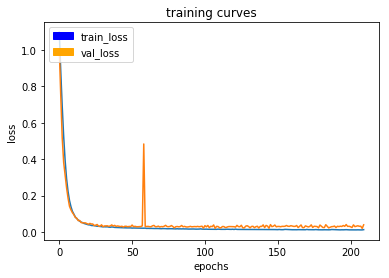

200/200 [==============================] - 120s - loss: 0.0124 - val_loss: 0.0389
Epoch 211/250
199/200 [============================>.] - ETA: 0s - loss: 0.0118

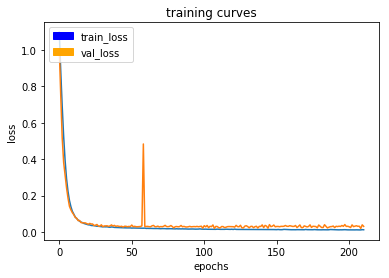

200/200 [==============================] - 120s - loss: 0.0119 - val_loss: 0.0305
Epoch 212/250
199/200 [============================>.] - ETA: 0s - loss: 0.0114

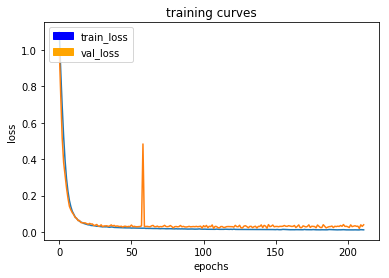

200/200 [==============================] - 120s - loss: 0.0114 - val_loss: 0.0391
Epoch 213/250
199/200 [============================>.] - ETA: 0s - loss: 0.0112

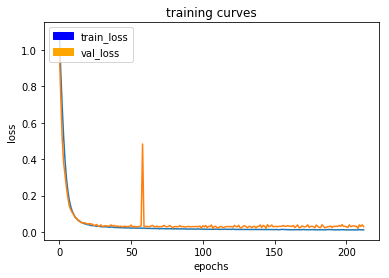

200/200 [==============================] - 120s - loss: 0.0112 - val_loss: 0.0286
Epoch 214/250
199/200 [============================>.] - ETA: 0s - loss: 0.0110

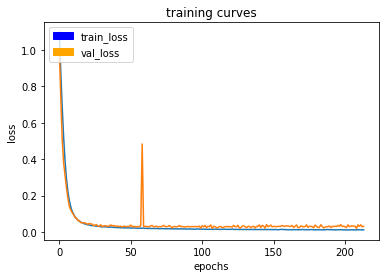

200/200 [==============================] - 120s - loss: 0.0110 - val_loss: 0.0303
Epoch 215/250
199/200 [============================>.] - ETA: 0s - loss: 0.0110

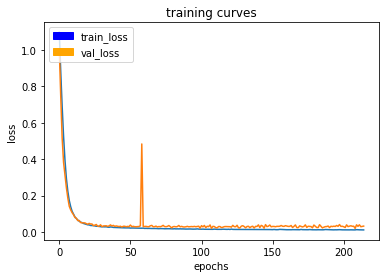

200/200 [==============================] - 120s - loss: 0.0110 - val_loss: 0.0318
Epoch 216/250
199/200 [============================>.] - ETA: 0s - loss: 0.0110

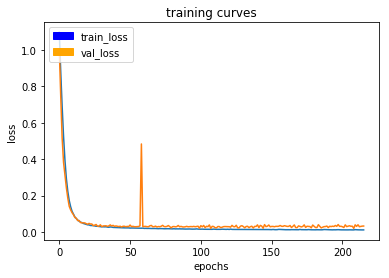

200/200 [==============================] - 121s - loss: 0.0110 - val_loss: 0.0322
Epoch 217/250
199/200 [============================>.] - ETA: 0s - loss: 0.0108

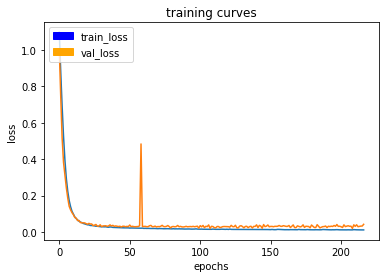

200/200 [==============================] - 120s - loss: 0.0109 - val_loss: 0.0416
Epoch 218/250
199/200 [============================>.] - ETA: 0s - loss: 0.0108

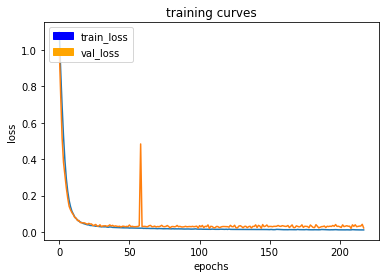

200/200 [==============================] - 120s - loss: 0.0108 - val_loss: 0.0217
Epoch 219/250
199/200 [============================>.] - ETA: 0s - loss: 0.0119

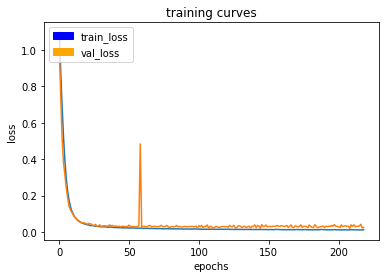

200/200 [==============================] - 120s - loss: 0.0119 - val_loss: 0.0244
Epoch 220/250
199/200 [============================>.] - ETA: 0s - loss: 0.0110

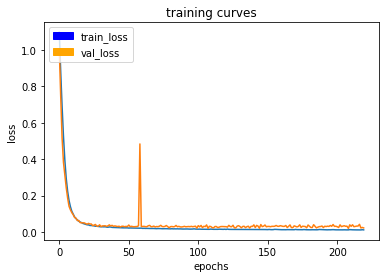

200/200 [==============================] - 120s - loss: 0.0110 - val_loss: 0.0218
Epoch 221/250
199/200 [============================>.] - ETA: 0s - loss: 0.0109

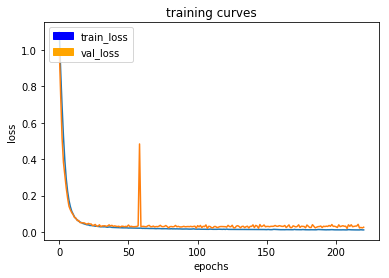

200/200 [==============================] - 120s - loss: 0.0109 - val_loss: 0.0257
Epoch 222/250
199/200 [============================>.] - ETA: 0s - loss: 0.0108

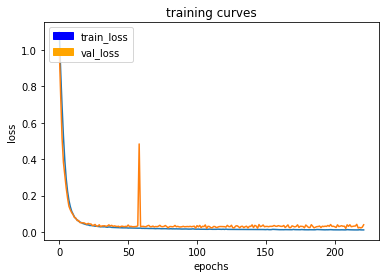

200/200 [==============================] - 121s - loss: 0.0108 - val_loss: 0.0390
Epoch 223/250
199/200 [============================>.] - ETA: 0s - loss: 0.0107

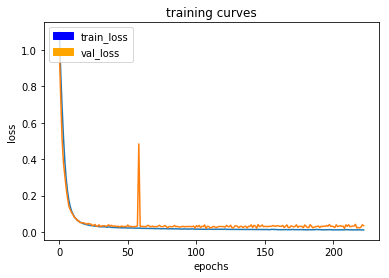

200/200 [==============================] - 120s - loss: 0.0107 - val_loss: 0.0345
Epoch 224/250
199/200 [============================>.] - ETA: 0s - loss: 0.0108

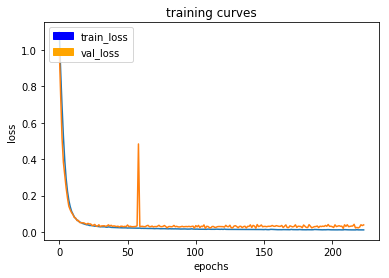

200/200 [==============================] - 120s - loss: 0.0108 - val_loss: 0.0384
Epoch 225/250
199/200 [============================>.] - ETA: 0s - loss: 0.0108

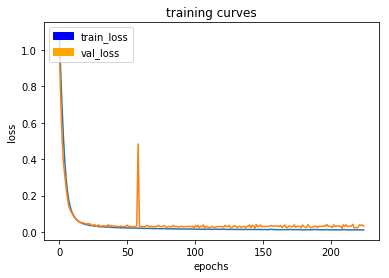

200/200 [==============================] - 120s - loss: 0.0108 - val_loss: 0.0308
Epoch 226/250
199/200 [============================>.] - ETA: 0s - loss: 0.0112

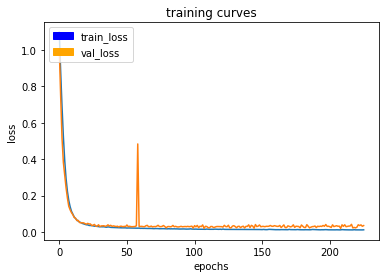

200/200 [==============================] - 120s - loss: 0.0113 - val_loss: 0.0346
Epoch 227/250
199/200 [============================>.] - ETA: 0s - loss: 0.0114

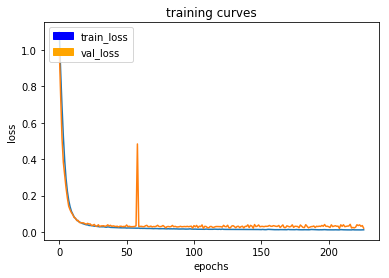

200/200 [==============================] - 120s - loss: 0.0114 - val_loss: 0.0204
Epoch 228/250
199/200 [============================>.] - ETA: 0s - loss: 0.0114

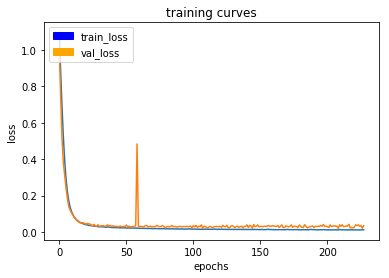

200/200 [==============================] - 120s - loss: 0.0114 - val_loss: 0.0344
Epoch 229/250
199/200 [============================>.] - ETA: 0s - loss: 0.0106

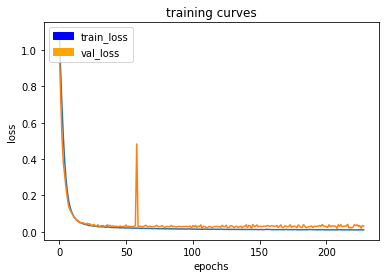

200/200 [==============================] - 120s - loss: 0.0106 - val_loss: 0.0317
Epoch 230/250
199/200 [============================>.] - ETA: 0s - loss: 0.0106

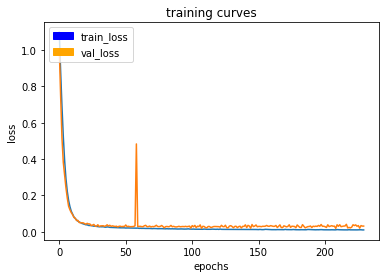

200/200 [==============================] - 120s - loss: 0.0106 - val_loss: 0.0317
Epoch 231/250
199/200 [============================>.] - ETA: 0s - loss: 0.0106

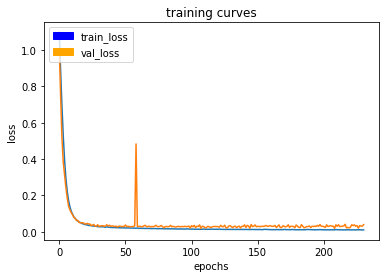

200/200 [==============================] - 121s - loss: 0.0106 - val_loss: 0.0395
Epoch 232/250
199/200 [============================>.] - ETA: 0s - loss: 0.0105

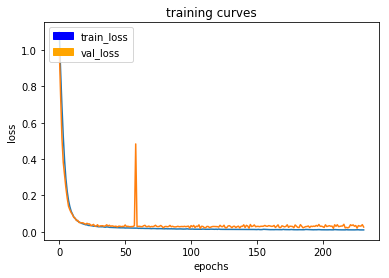

200/200 [==============================] - 120s - loss: 0.0105 - val_loss: 0.0263
Epoch 233/250
199/200 [============================>.] - ETA: 0s - loss: 0.0106

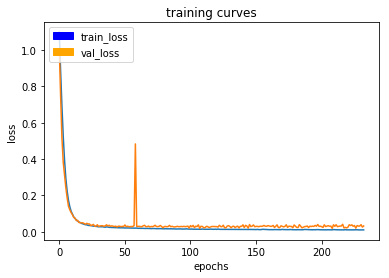

200/200 [==============================] - 120s - loss: 0.0106 - val_loss: 0.0321
Epoch 234/250
199/200 [============================>.] - ETA: 0s - loss: 0.0107

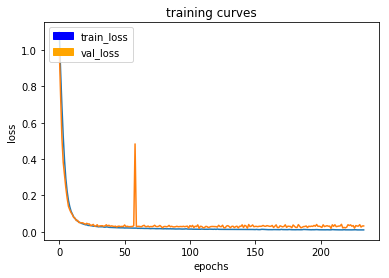

200/200 [==============================] - 120s - loss: 0.0107 - val_loss: 0.0325
Epoch 235/250
199/200 [============================>.] - ETA: 0s - loss: 0.0120

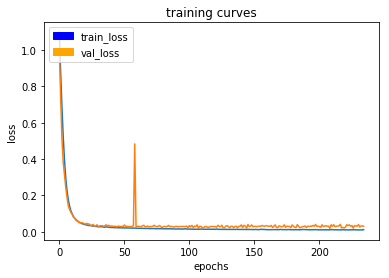

200/200 [==============================] - 120s - loss: 0.0120 - val_loss: 0.0306
Epoch 236/250
199/200 [============================>.] - ETA: 0s - loss: 0.0114

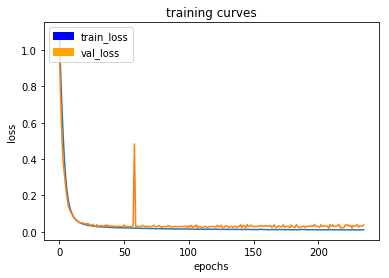

200/200 [==============================] - 121s - loss: 0.0114 - val_loss: 0.0384
Epoch 237/250
199/200 [============================>.] - ETA: 0s - loss: 0.0109

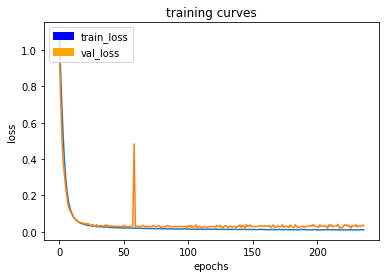

200/200 [==============================] - 120s - loss: 0.0109 - val_loss: 0.0331
Epoch 238/250
199/200 [============================>.] - ETA: 0s - loss: 0.0107

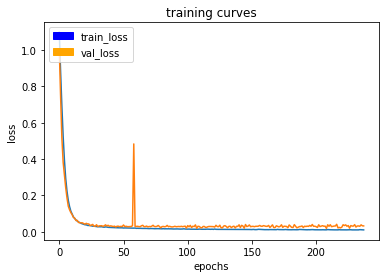

200/200 [==============================] - 120s - loss: 0.0107 - val_loss: 0.0326
Epoch 239/250
199/200 [============================>.] - ETA: 0s - loss: 0.0105

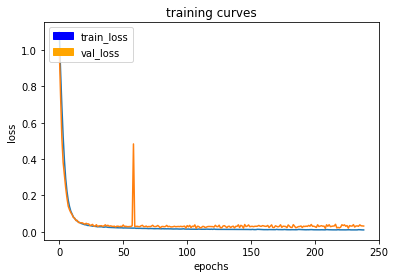

200/200 [==============================] - 120s - loss: 0.0105 - val_loss: 0.0318
Epoch 240/250
199/200 [============================>.] - ETA: 0s - loss: 0.0105

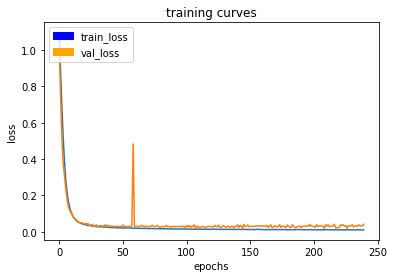

200/200 [==============================] - 120s - loss: 0.0105 - val_loss: 0.0411
Epoch 241/250
199/200 [============================>.] - ETA: 0s - loss: 0.0109

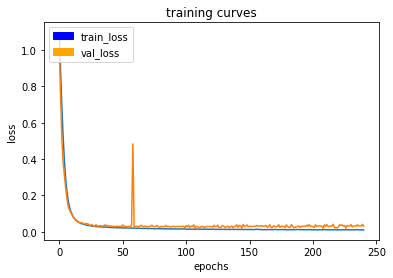

200/200 [==============================] - 120s - loss: 0.0109 - val_loss: 0.0309
Epoch 242/250
199/200 [============================>.] - ETA: 0s - loss: 0.0108

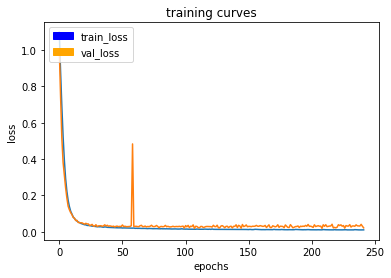

200/200 [==============================] - 120s - loss: 0.0108 - val_loss: 0.0218
Epoch 243/250
199/200 [============================>.] - ETA: 0s - loss: 0.0111

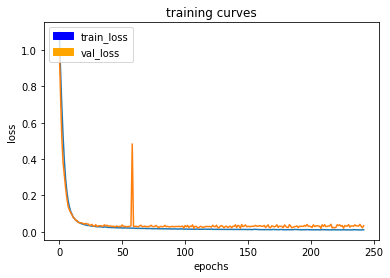

200/200 [==============================] - 120s - loss: 0.0111 - val_loss: 0.0339
Epoch 244/250
199/200 [============================>.] - ETA: 0s - loss: 0.0106

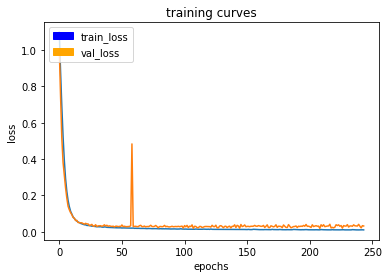

200/200 [==============================] - 120s - loss: 0.0106 - val_loss: 0.0321
Epoch 245/250
199/200 [============================>.] - ETA: 0s - loss: 0.0106

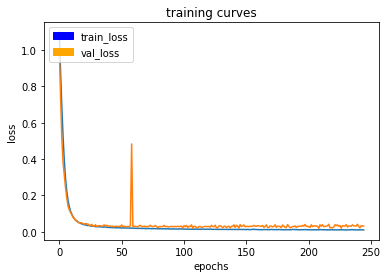

200/200 [==============================] - 120s - loss: 0.0106 - val_loss: 0.0316
Epoch 246/250
199/200 [============================>.] - ETA: 0s - loss: 0.0105

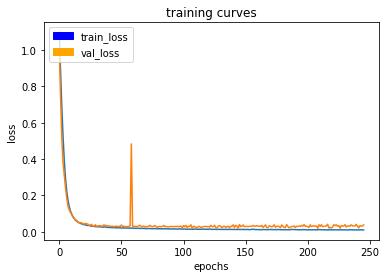

200/200 [==============================] - 121s - loss: 0.0105 - val_loss: 0.0385
Epoch 247/250
199/200 [============================>.] - ETA: 0s - loss: 0.0104

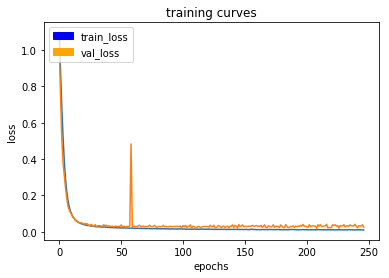

200/200 [==============================] - 121s - loss: 0.0104 - val_loss: 0.0254
Epoch 248/250
199/200 [============================>.] - ETA: 0s - loss: 0.0103

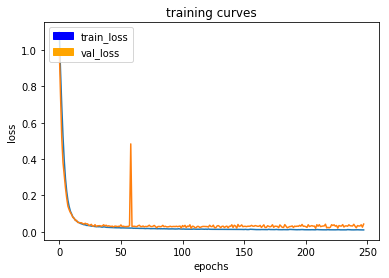

200/200 [==============================] - 120s - loss: 0.0103 - val_loss: 0.0424
Epoch 249/250
199/200 [============================>.] - ETA: 0s - loss: 0.0104

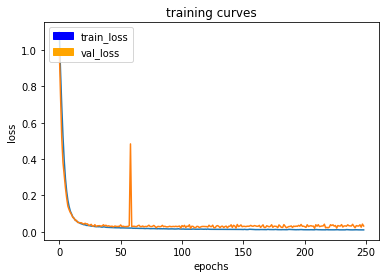

200/200 [==============================] - 121s - loss: 0.0104 - val_loss: 0.0317
Epoch 250/250
199/200 [============================>.] - ETA: 0s - loss: 0.0103

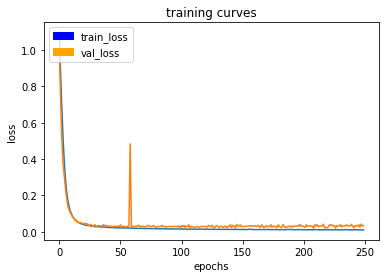

200/200 [==============================] - 121s - loss: 0.0103 - val_loss: 0.0343


In [38]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [39]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [40]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

weight_file_name = 'model_weights'
restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [41]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

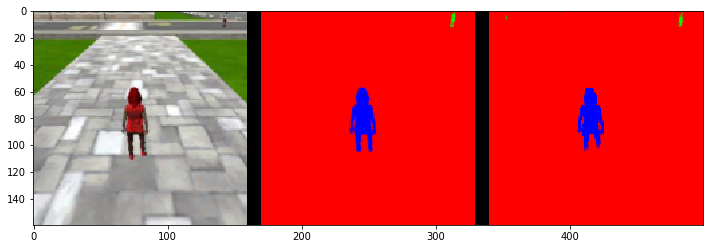

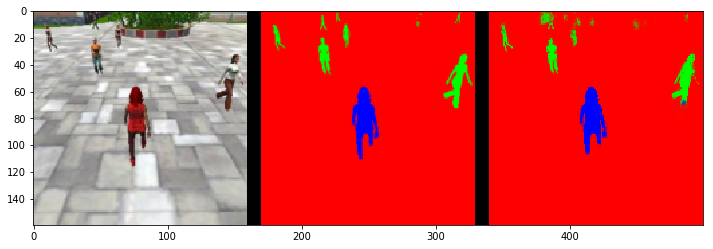

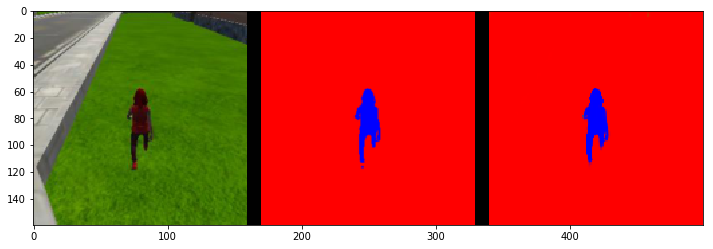

In [42]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

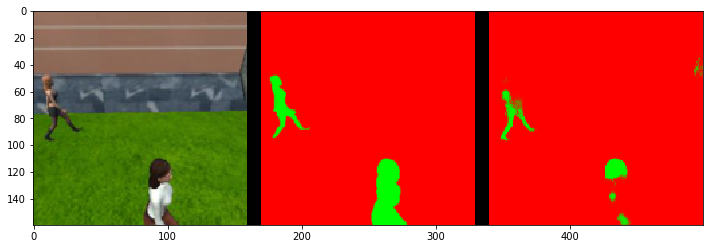

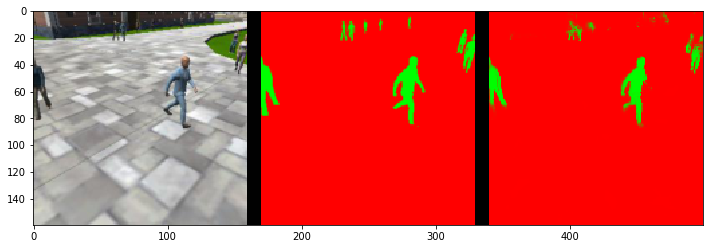

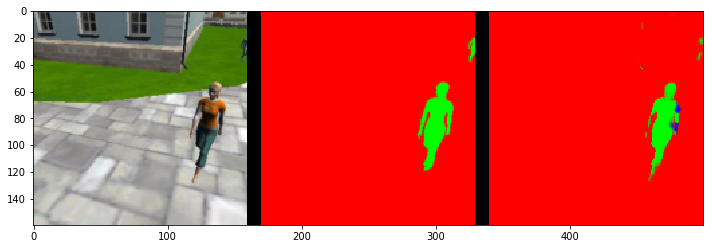

In [43]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

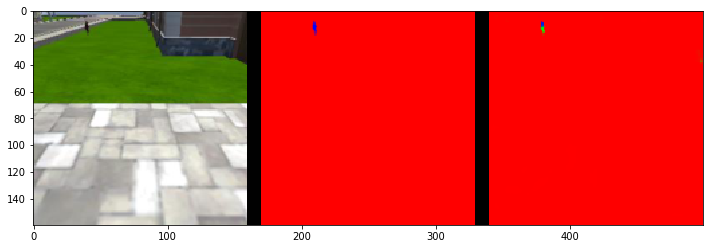

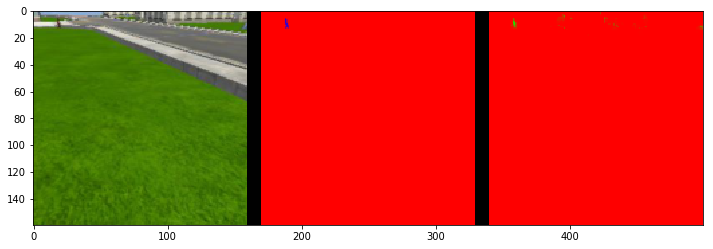

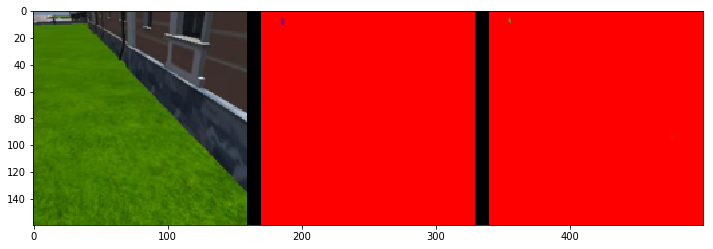

In [44]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [45]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9956999323286286
average intersection over union for other people is 0.3574688726182162
average intersection over union for the hero is 0.9092085820143321
number true positives: 539, number false positives: 0, number false negatives: 0


In [46]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9864994555021114
average intersection over union for other people is 0.726182015702372
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 75, number false negatives: 0


In [47]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9960200297752451
average intersection over union for other people is 0.4348827652611433
average intersection over union for the hero is 0.19699471130536952
number true positives: 128, number false positives: 2, number false negatives: 173


In [48]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7273718647764449


In [49]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.5531016466598508


In [50]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.402310576141898
